![Screenshot 2024-12-14 132232.png](<attachment:Screenshot 2024-12-14 132232.png>)
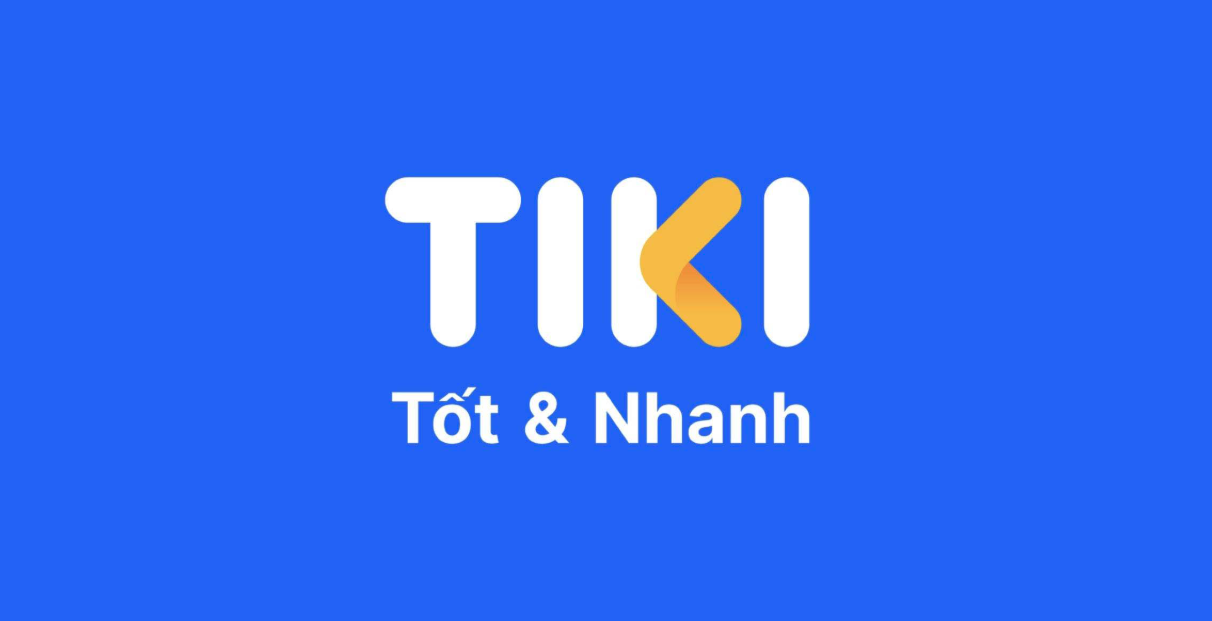

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

In [1]:
# import the packages
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/12/14 10:21:13 WARN Utils: Your hostname, DESKTOP-PABD4FS resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/14 10:21:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/14 10:21:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/14 10:21:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/14 10:21:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Step 1: Data Loading and Data Cleansing

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg, year, month, dayofweek, trim, lower, to_date, expr
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, sum, desc
import matplotlib.pyplot as plt

# Load the data from CSV file with proper options
df = spark.read.option("quote", "\"") \
                .option("escape", "\"") \
                .option("multiLine", "true") \
                .option("delimiter", ",") \
                .csv("./ASG1_vietnamese_tiki_products_mod.csv", header=True, inferSchema=True)

# Show the DataFrame schema and first few rows
df.printSchema()
df.show(10)

# Count rows and columns in the dataset
num_rows = df.count()
num_cols = len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")

# Data cleaning and preprocessing
# Check for null values and anomalies
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Group by 'id' and count the occurrences of each 'id'
duplicate_ids_df = df.groupBy("id").count()

# Filter to find ids with duplicates (count > 1)
duplicate_ids = duplicate_ids_df.filter("count > 1")

# Sum up the number of duplicate rows by subtracting 1 from the count for each duplicate (to exclude the first occurrence)
duplicate_rows_count = duplicate_ids.select(F.sum(duplicate_ids["count"] - 1)).collect()[0][0]

print(f"Number of duplicate rows with the same 'id': {duplicate_rows_count}")

# Drop duplicate rows based on the 'id' column
df = df.dropDuplicates(["id"])

# Total number of rows
df_num_rows = df.count()

# Total number of columns
df_num_columns = len(df.columns)

# Print the results
print(f"Total number of rows: {df_num_rows}")
print(f"Total number of columns: {df_num_columns}")

# Show the updated dataframe after dropping duplicates
df.show()

# Filter rows where price is 0 and display them
price_zero_df = df.filter(df['price'] <= 0)
price_zero_df.show()

# Filter out rows where price is 0
df = df.filter(df['price'] != 0)

# Total number of rows after filtering
num_rows = df.count()
print(f"Total number of rows after filtering: {num_rows}")

# Filter rows where product_type is "No Brand"
no_brand_df = df.filter(df.brand == "No Brand")
print(f"Count of 'No Brand': {no_brand_df.count()}")

# First Round of Data Cleaning (Replacing values with OEM)
df_cleaned = df.withColumn(
    "brand",
    when(df["brand"] == "No Brand", "OEM")
     .when(df["brand"] == "\tOEM", "OEM")
     .when(df["brand"] == " OEM(Error)", "OEM")
     .when(df["brand"] == "OEM1", "OEM")          
     .otherwise(df["brand"])
)
# After cross referencing the number of rows with OEM as the product brand, 
# identified the column ' OEM' still has missing 8 rows that werent mapped to the actual correct category 'OEM'.

# Show the updated DataFrame after cleaning brands
df_cleaned.show()

# Filter rows where 'brand' column contains the string "OEM"
filtered_df_brand = df_cleaned.filter(df_cleaned["brand"].contains("OEM"))

# Show the unique categories under the 'brand' column that contain "OEM"
filtered_df_brand.select("brand").distinct().show()

oem_set = set(filtered_df_brand.select("brand").distinct().rdd.flatMap(lambda x: x).collect())
print(oem_set)

# Second Round of Data Cleaning (Replace)
df_cleaned_2 = df_cleaned.withColumn(
    "brand",
    when(trim(df_cleaned["brand"]) == " OEM", "OEM")   
     .otherwise(df_cleaned["brand"])
)

# Show the updated DataFrame after second cleaning round
df_cleaned_2.show()

# Clean the 'current_seller' column by removing extra spaces and converting to lowercase
cleaned_CS_df = df_cleaned_2.withColumn("current_seller_cleaned", lower(trim(df_cleaned_2["current_seller"])))

# Show unique cleaned sellers
unique_sellers_cleaned = cleaned_CS_df.select("current_seller_cleaned").distinct().collect()
print([row['current_seller_cleaned'] for row in unique_sellers_cleaned])

# Third round of Data cleaning
# Filter rows where price is 0 and display them
abnormal_days_df = cleaned_CS_df.filter(cleaned_CS_df['date_created'] >= 4999)
abnormal_days_df.show()

# Filter out rows where the number of days from last update date and created date (date_created) is larger than 4999
# because the company Tiki Vietnam was only founded in March 2010, so any greater than 4999 since 13th Septemmber 2023(when the dataset was posted)
# shows that the data is invalid
cleaned_CS_df_2 = cleaned_CS_df.filter(cleaned_CS_df['date_created'] <= 4999)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- favourite_count: integer (nullable = true)
 |-- pay_later: boolean (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- has_video: boolean (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)

+---------+--------------------+--------------------+--------------+-----+----------------+------+------------+--------------+---------------+---------+--------------------+------------+----------------+---------

24/12/14 10:21:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|     id|                name|         description|original_price|  price|fulfillment_type|       brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
| 565573|Sakos suitcase Ch...|Sakos Champion 5 ...|       2189000|1858000|        dropship|       Sakos|           0|           0.0|              0|     true|          Balonation|           0|       

{'OEM', 'B21 B21 SHOEMAKER', ' OEM'}
+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|     id|                name|         description|original_price|  price|fulfillment_type|       brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
| 565573|Sakos suitcase Ch...|Sakos Champion 5 ...|       2189000|1858000|        dropship|       Sakos|           0|           0.0|              0|     true|    

In [3]:
cleaned_CS_df_2.show()

+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+
|     id|                name|         description|original_price|  price|fulfillment_type|       brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|current_seller_cleaned|
+-------+--------------------+--------------------+--------------+-------+----------------+------------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+
| 565573|Sakos suitcase Ch...|Sakos Champion 5 ...|       2189000|1858000|        dropship|       Sakos|           0|           0.

In [4]:
# Total number of rows
cleaned_CS_df_2_num_rows = cleaned_CS_df_2.count()

# Total number of columns
cleaned_CS_df_2_num_columns = len(cleaned_CS_df_2.columns)

# Print the results
print(f"Total number of rows: {cleaned_CS_df_2_num_rows}")
print(f"Total number of columns: {cleaned_CS_df_2_num_columns}")

Total number of rows: 37125
Total number of columns: 19


In [5]:
df_filtered = cleaned_CS_df_2.drop("id", "name", "description", "favourite_count")
df_filtered.show()

+--------------+-------+----------------+---------------+------------+--------------+---------+------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+
|original_price|  price|fulfillment_type|          brand|review_count|rating_average|pay_later|    current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|current_seller_cleaned|
+--------------+-------+----------------+---------------+------------+--------------+---------+------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+
|       2189000|1858000|        dropship|          Sakos|           0|           0.0|     true|        Balonation|           0|               5|           0|    false|backpacks_suitcases|            1|            balonation|
|       2585000|2585000|        dropship|          Sakos|           0|           0.0|     true|     

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, to_date

# Calculate price difference
df_filtered = df_filtered.withColumn("price_difference", col("original_price") - col("price"))

# Calculate the Actual Last Update Date                       
reference_date = "2023-09-13"  # Replace with your reference date
df_filtered = df_filtered.withColumn("last_update_date", to_date(lit(reference_date)) - col("date_created"))

# Extract day of the week, month, and year from last_update_date
df_filtered = df_filtered.withColumn(
    "day_of_week", F.date_format(col("last_update_date"), "E")  # Day of the week (e.g., Mon)
).withColumn(
    "month", F.month(col("last_update_date"))  # Month as a number (1-12)
).withColumn(
    "year", F.year(col("last_update_date"))  # Year as a number (e.g., 2024)
)
# Show the updated DataFrame with new columns
df_filtered.show()                       

# Not Helpful                       
# # Image presence feature
# df_filtered = df_filtered.withColumn("has_images", when(col("number_of_images") > 0, 1).otherwise(0))

# Seller product count feature
seller_count_df = df_filtered.groupBy("current_seller_cleaned").count().withColumnRenamed("count", "seller_product_count")
df_filtered = df_filtered.join(seller_count_df, on="current_seller_cleaned", how="left")

# Brand product count feature
brand_count_df = df_filtered.groupBy("brand").count().withColumnRenamed("count", "brand_product_count")
df_filtered = df_filtered.join(brand_count_df, on="brand", how="left")

# Video presence feature
df_filtered = df_filtered.withColumn("has_video_binary", when(col("has_video") == "TRUE", 1).otherwise(0))

# Pay Later Program presence feature
df_filtered = df_filtered.withColumn("pay_later_binary", when(col("pay_later") == "TRUE", 1).otherwise(0))

# Show updated DataFrame with new features
df_filtered.show()

+--------------+-------+----------------+---------------+------------+--------------+---------+------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+----------------+----------------+-----------+-----+----+
|original_price|  price|fulfillment_type|          brand|review_count|rating_average|pay_later|    current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|current_seller_cleaned|price_difference|last_update_date|day_of_week|month|year|
+--------------+-------+----------------+---------------+------------+--------------+---------+------------------+------------+----------------+------------+---------+-------------------+-------------+----------------------+----------------+----------------+-----------+-----+----+
|       2189000|1858000|        dropship|          Sakos|           0|           0.0|     true|        Balonation|           0|               5|          

In [7]:
df_filtered.printSchema()

root
 |-- brand: string (nullable = true)
 |-- current_seller_cleaned: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- pay_later: boolean (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- has_video: boolean (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)
 |-- price_difference: integer (nullable = true)
 |-- last_update_date: date (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- seller_product_count: long (nullable = true)
 |-- brand_product_count: long (nullable = true)
 |-- has_

In [8]:
# Filter rows where price is 0 and display them
abnormal_days_df = df_filtered.filter(df_filtered['date_created'] >= 4999)
abnormal_days_df.show()

+-----+----------------------+--------------+-----+----------------+------------+--------------+---------+--------------+------------+----------------+------------+---------+------------+-------------+----------------+----------------+-----------+-----+----+--------------------+-------------------+----------------+----------------+
|brand|current_seller_cleaned|original_price|price|fulfillment_type|review_count|rating_average|pay_later|current_seller|date_created|number_of_images|vnd_cashback|has_video|product_type|quantity_sold|price_difference|last_update_date|day_of_week|month|year|seller_product_count|brand_product_count|has_video_binary|pay_later_binary|
+-----+----------------------+--------------+-----+----------------+------------+--------------+---------+--------------+------------+----------------+------------+---------+------------+-------------+----------------+----------------+-----------+-----+----+--------------------+-------------------+----------------+----------------

In [9]:
df_filtered = df_filtered.drop ("has_video", "pay_later", "last_update_date")

In [10]:
df_filtered.printSchema()

root
 |-- brand: string (nullable = true)
 |-- current_seller_cleaned: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)
 |-- price_difference: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- seller_product_count: long (nullable = true)
 |-- brand_product_count: long (nullable = true)
 |-- has_video_binary: integer (nullable = false)
 |-- pay_later_binary: integer (nullable = false)



### Step 2: Exploratory Data Analysis

In [11]:
# product_type
from pyspark.sql.functions import desc
PT_grouped_count_df = df_filtered.groupBy("product_type").count().orderBy(desc("count"))

# Show the grouped data
PT_grouped_count_df.show()

+-------------------+-----+
|       product_type|count|
+-------------------+-----+
|fashion_accessories|14122|
|        women_shoes| 5300|
|          men_shoes| 5297|
|         women_bags| 4151|
|backpacks_suitcases| 4130|
|           men_bags| 4125|
+-------------------+-----+



In [12]:
# Count distinct categories for the 'Gender' column
distinct_count = PT_grouped_count_df.select("product_type").distinct().count()

# Show the result
print(f"Number of distinct categories in 'product_type': {distinct_count}")

Number of distinct categories in 'product_type': 6


In [13]:
# brand
from pyspark.sql.functions import desc
B_grouped_count_df = df_filtered.groupBy("brand").count().orderBy(desc("count"))

# Show the grouped data
B_grouped_count_df.show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|                 OEM|27859|
|         Song An Eco|  445|
|           Huy Hoàng|  320|
|          Hạnh Dương|  213|
|            Converse|  176|
|              GOMTAT|  170|
|Trương Gia Túi Vả...|  167|
|              Rosata|  162|
|             BIGGBEN|  161|
|             Bee Gee|  160|
|         ANANSHOP688|  153|
|              Macsim|  139|
|              OURESS|  136|
|                Ximo|  119|
|               Gence|  112|
|              Biti's|  112|
|               Crocs|  109|
|               Sakos|  104|
|           LQ luxury|  104|
|Fairy Shop Contac...|   97|
+--------------------+-----+
only showing top 20 rows



In [14]:
# Count distinct categories for the 'Gender' column
distinct_count = B_grouped_count_df.select("brand").distinct().count()

# Show the result
print(f"Number of distinct categories in 'brand': {distinct_count}")

Number of distinct categories in 'brand': 782


In [15]:
# fulfillment_type
FT_grouped_count_df = df_filtered.groupBy("fulfillment_type").count().orderBy(desc("count"))
from pyspark.sql.functions import desc

# Show the grouped data
FT_grouped_count_df.show()
# spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
# pyspark_df

+----------------+-----+
|fulfillment_type|count|
+----------------+-----+
|        dropship|36320|
|   tiki_delivery|  621|
| seller_delivery|  184|
+----------------+-----+



In [16]:
# Count distinct categories for the 'Gender' column
distinct_count = FT_grouped_count_df.select("fulfillment_type").distinct().count()

# Show the result
print(f"Number of distinct categories in 'fulfillment_type': {distinct_count}")

Number of distinct categories in 'fulfillment_type': 3


In [17]:
# current_seller
CS_grouped_count_df = df_filtered.groupBy("current_seller_cleaned").count().orderBy(desc("count"))
from pyspark.sql.functions import desc

# Show the grouped data
CS_grouped_count_df.show()

+----------------------+-----+
|current_seller_cleaned|count|
+----------------------+-----+
|                shalla|  474|
|              tlg gold|  365|
|  thanh long tlg le...|  319|
|                   hat|  313|
|   vn24h leather shoes|  285|
|  the world of stor...|  275|
|            store shoe|  258|
|              ant home|  235|
|             store 247|  233|
|       pure vietnamese|  222|
|          dona fashion|  215|
|   hanh duong official|  213|
|  embedded programm...|  191|
|  genuine leather s...|  179|
|   supersports vietnam|  179|
|  truong gia canvas...|  167|
|          shoes bigben|  165|
|  az embedded progr...|  162|
|          shopducthang|  161|
|  wedding accessori...|  161|
+----------------------+-----+
only showing top 20 rows



In [18]:
# Count distinct categories for the 'Gender' column
distinct_count = df_filtered.select("current_seller_cleaned").distinct().count()

# Show the result
print(f"Number of distinct categories in 'current_seller_cleaned': {distinct_count}")

Number of distinct categories in 'current_seller_cleaned': 3671


In [19]:
# product_type
from pyspark.sql.functions import desc
day_grouped_count_df = df_filtered.groupBy("day_of_week").count().orderBy(desc("count"))

# Show the grouped data
day_grouped_count_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        Wed| 6956|
|        Fri| 6743|
|        Thu| 6170|
|        Sat| 5937|
|        Sun| 5029|
|        Tue| 3473|
|        Mon| 2817|
+-----------+-----+



In [20]:
# Count distinct categories for the 'Gender' column
distinct_count = day_grouped_count_df.select("day_of_week").distinct().count()

# Show the result
print(f"Number of distinct categories in 'product_type': {distinct_count}")

Number of distinct categories in 'product_type': 7


In [21]:
# product_type
from pyspark.sql.functions import desc
month_grouped_count_df = df_filtered.groupBy("month").count().orderBy(desc("count"))

# Show the grouped data
month_grouped_count_df.show()

+-----+-----+
|month|count|
+-----+-----+
|    3| 4166|
|    4| 3827|
|    6| 3638|
|    5| 3528|
|   11| 3508|
|   12| 3427|
|    7| 3282|
|   10| 2802|
|    9| 2518|
|    8| 2504|
|    2| 2235|
|    1| 1690|
+-----+-----+



In [22]:
# Count distinct categories for the 'Gender' column
distinct_count = month_grouped_count_df.select("month").distinct().count()

# Show the result
print(f"Number of distinct categories in 'product_type': {distinct_count}")

Number of distinct categories in 'product_type': 12


In [23]:
# product_type
from pyspark.sql.functions import desc
year_grouped_count_df = df_filtered.groupBy("year").count().orderBy(desc("count"))

# Show the grouped data
year_grouped_count_df.show()

+----+-----+
|year|count|
+----+-----+
|2022|14080|
|2021|13414|
|2023| 4551|
|2020| 2293|
|2019| 2095|
|2018|  634|
|2017|   57|
|2015|    1|
+----+-----+



In [24]:
# Count distinct categories for the 'Gender' column
distinct_count = year_grouped_count_df.select("year").distinct().count()

# Show the result
print(f"Number of distinct categories in 'product_type': {distinct_count}")

Number of distinct categories in 'product_type': 8


In [25]:
# Tiki Vietnam's brand colour palette (Company Colour Palette)
color_palette = ['#0263fd', '#ffb620', '#669efc', '#0057c8', '#f4c23e', '#2d2d2d', '#77a8d9', '#d32f2f']

In [26]:
# Set the color palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_palette)

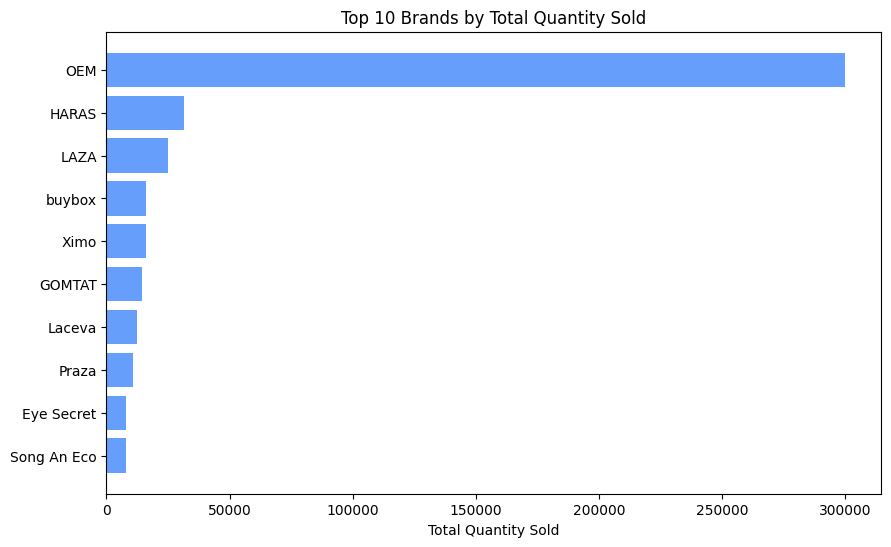

In [27]:
# 1. Total Quantity Sold by Brand
quantity_sold_by_brand = df_filtered.groupBy("brand").agg(sum("quantity_sold").alias("total_quantity_sold"))
quantity_sold_by_brand = quantity_sold_by_brand.orderBy(desc("total_quantity_sold")).limit(10)

# Collecting data for plotting
brands = [row['brand'] for row in quantity_sold_by_brand.collect()]
quantities = [row['total_quantity_sold'] for row in quantity_sold_by_brand.collect()]

# Plotting Total Quantity Sold by Brand
plt.figure(figsize=(10, 6))
plt.barh(brands, quantities, color=color_palette[2]) # Tiki Vietnam's brand colours
plt.xlabel('Total Quantity Sold')
plt.title('Top 10 Brands by Total Quantity Sold')
plt.gca().invert_yaxis()  # Invert y axis to have the highest bar on top
plt.show()

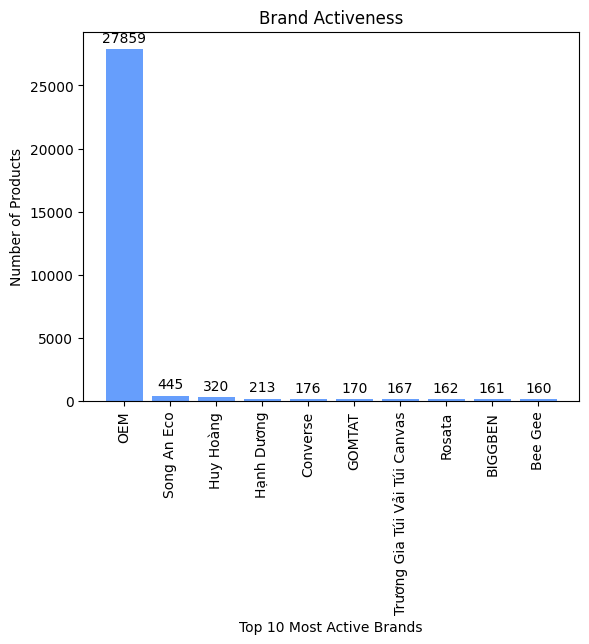

In [28]:
# Most Active Brands and products per brand
brand_counts = df_filtered.groupBy("brand").count().orderBy("count", ascending=False).limit(10)
brand_counts_list = brand_counts.collect()

# Prepare data for plotting
brands = [row['brand'] for row in brand_counts_list]
counts = [row['count'] for row in brand_counts_list]

# Plotting bar chart
plt.bar(brands, counts,  color=color_palette[2]) # Tiki Vietnam's brand colours
plt.title('Brand Activeness')
# Adding data labels
for i, txt in enumerate(counts):
    plt.annotate(f"{txt}", (brands[i], counts[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel('Top 10 Most Active Brands')
plt.ylabel('Number of Products')
plt.xticks(rotation=90)
plt.show()

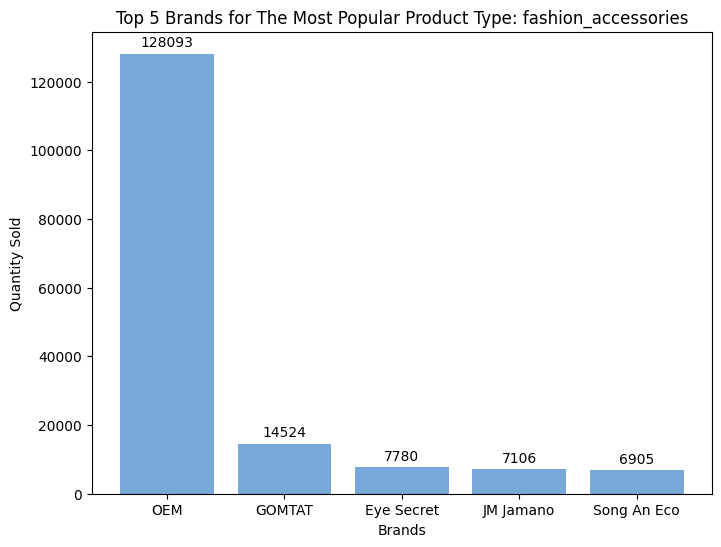

In [29]:
# Step 1: Aggregate by product_type
product_popularity = df.groupBy("product_type") \
    .sum("quantity_sold") \
    .withColumnRenamed("sum(quantity_sold)", "total_sold") \
    .orderBy(desc("total_sold"))

# Step 2: Identify most popular product_type
most_popular_product_type = product_popularity.first()["product_type"]

# Step 3: Filter for the most popular product_type and find top 5 brands
top_brands = df.filter(col("product_type") == most_popular_product_type) \
    .groupBy("brand") \
    .sum("quantity_sold") \
    .withColumnRenamed("sum(quantity_sold)", "total_sold") \
    .orderBy(desc("total_sold")) \
    .limit(5)

# Collect results for visualization
top_brands_data = top_brands.collect()
brands = [row["brand"] for row in top_brands_data]
sales = [row["total_sold"] for row in top_brands_data]

# Step 4: Visualization using Matplotlib (No Pandas)
# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(brands, sales, color=color_palette[6]) # Tiki Vietnam's brand colours
# Adding data labels
for i, txt in enumerate(sales):
    plt.annotate(f"{txt}", (brands[i], sales[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel("Brands")
plt.ylabel("Quantity Sold")
plt.title(f"Top 5 Brands for The Most Popular Product Type: {most_popular_product_type}")
plt.show()

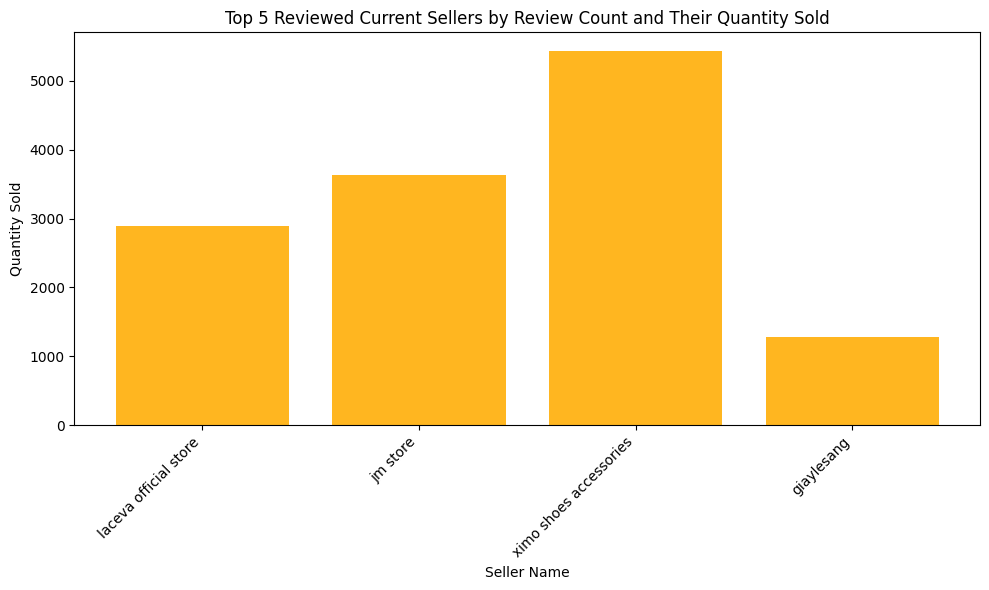

In [30]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Use orderBy with a column for sorting
df_filtered = df_filtered.orderBy(col("review_count").desc())

# Now you can extract the top 5 sellers
top_sellers = df_filtered.limit(5).collect()

# Extract data for the top 5 sellers
sellers = [seller['current_seller_cleaned'] for seller in top_sellers]
quantity_sold = [seller['quantity_sold'] for seller in top_sellers]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sellers, quantity_sold, color=color_palette[1]) # Tiki Vietnam's brand colours
plt.xlabel("Seller Name")
plt.ylabel("Quantity Sold")
plt.title("Top 5 Reviewed Current Sellers by Review Count and Their Quantity Sold")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

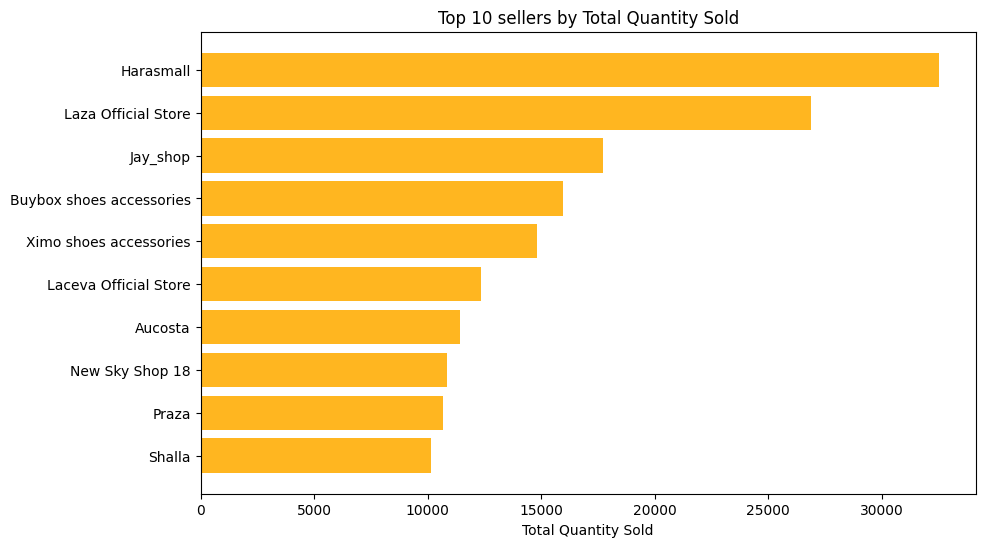

In [31]:
# 1. Total Quantity Sold by Current Sellers
quantity_sold_by_seller = df_filtered.groupBy("current_seller").agg(sum("quantity_sold").alias("total_quantity_sold"))
quantity_sold_by_seller = quantity_sold_by_seller.orderBy(desc("total_quantity_sold")).limit(10)

# Collecting data for plotting
seller = [row['current_seller'] for row in quantity_sold_by_seller.collect()]
quantities = [row['total_quantity_sold'] for row in quantity_sold_by_seller.collect()]

# Plotting Total Quantity Sold by Brand
plt.figure(figsize=(10, 6))
plt.barh(seller, quantities, color=color_palette[1]) # Tiki Vietnam's brand colours
plt.xlabel('Total Quantity Sold')
plt.title('Top 10 sellers by Total Quantity Sold')
plt.gca().invert_yaxis()  # Invert y axis to have the highest bar on top
plt.show()

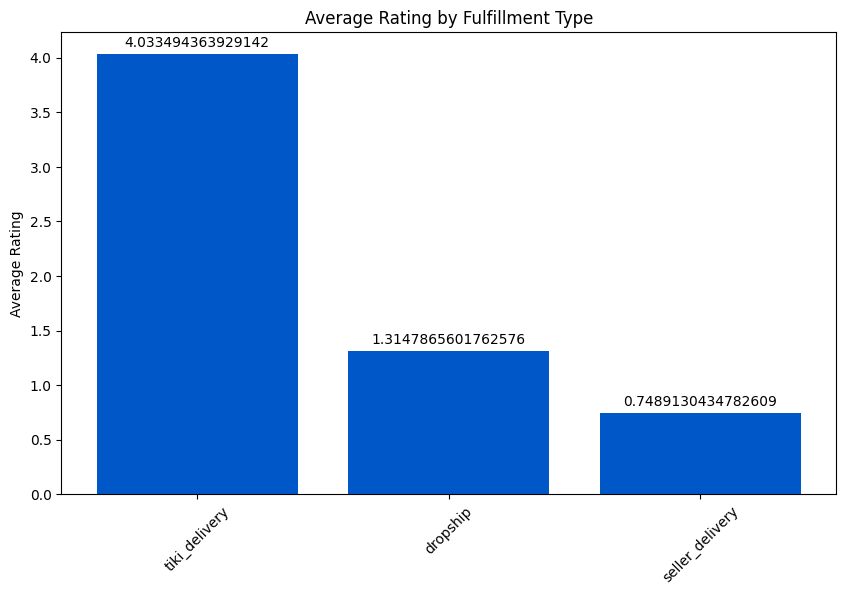

In [32]:
# 2. Average Rating by Fulfillment Type
avg_rating_by_fulfillment = df_filtered.groupBy("fulfillment_type").agg(avg("rating_average").alias("avg_rating"))
avg_rating_by_fulfillment = avg_rating_by_fulfillment.orderBy(desc("avg_rating"))

# Collecting data for plotting
fulfillment_types = [row['fulfillment_type'] for row in avg_rating_by_fulfillment.collect()]
avg_ratings = [row['avg_rating'] for row in avg_rating_by_fulfillment.collect()]

# Plotting Average Rating by Fulfillment Type
plt.figure(figsize=(10, 6))
plt.bar(fulfillment_types, avg_ratings, color=color_palette[3]) # Tiki Vietnam's brand colours
# Adding data labels
for i, txt in enumerate(avg_ratings):
    plt.annotate(f"{txt}", (fulfillment_types[i], avg_ratings[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.ylabel('Average Rating')
plt.title('Average Rating by Fulfillment Type')
plt.xticks(rotation=45)
plt.show()

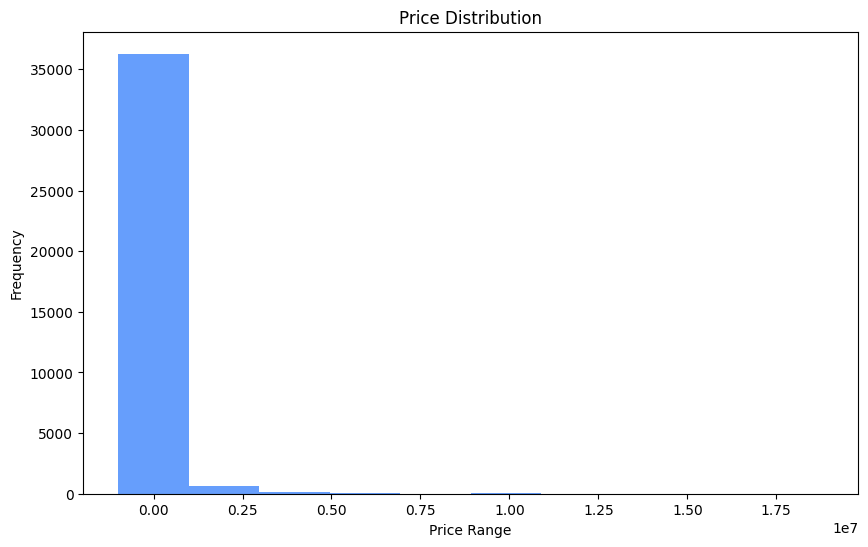

In [33]:
# 3. Distribution of Price
price_distribution = df_filtered.select("price").rdd.flatMap(lambda x: x).histogram(10)  # Create histogram with 10 bins

# Plotting Price Distribution
plt.figure(figsize=(10, 6))
plt.bar(price_distribution[0][:-1], price_distribution[1], 
        width=price_distribution[0][1] - price_distribution[0][0],  color=color_palette[2]) # Tiki Vietnam's brand colours
plt.xlabel('Price Range')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

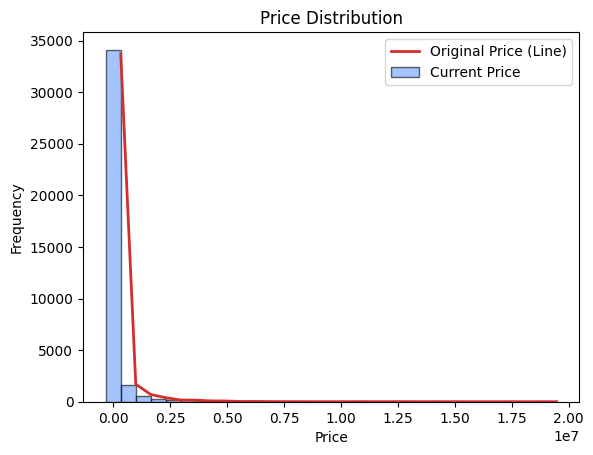

In [34]:
# Collect original and current prices as RDDs
original_prices = df_filtered.select("original_price").rdd.flatMap(lambda x: x)
current_prices = df_filtered.select("price").rdd.flatMap(lambda x: x)

# Compute histogram data for current prices
current_hist_data = current_prices.histogram(30)  # PySpark's histogram returns bin edges and counts
current_bin_edges, current_counts = current_hist_data[0], current_hist_data[1]

# Compute histogram data for original prices
original_hist_data = original_prices.histogram(current_bin_edges)  # Use same bin edges for alignment
original_counts = original_hist_data[1]

# Calculate bin centers for the line chart
bin_centers = [(current_bin_edges[i] + current_bin_edges[i + 1]) / 2 for i in range(len(current_bin_edges) - 1)]

# Plotting
plt.bar(current_bin_edges[:-1], current_counts, width=[current_bin_edges[i + 1] - current_bin_edges[i] for i in range(len(current_bin_edges) - 1)],
        alpha=0.6, label='Current Price', edgecolor='black', color=color_palette[2])# Tiki Vietnam's brand colours

plt.plot(bin_centers, original_counts, label='Original Price (Line)', color=color_palette[7], linewidth=2)# Tiki Vietnam's brand colours

# Add labels, title, and legend
plt.legend(loc='upper right')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

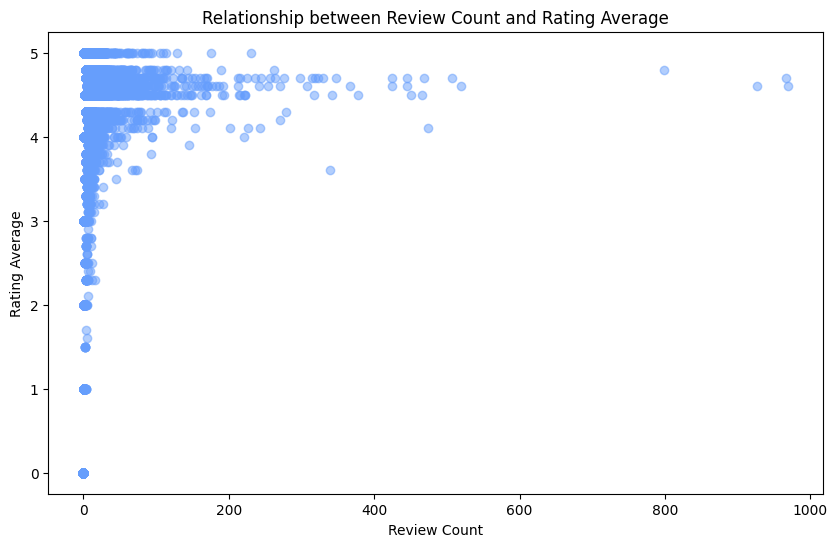

In [35]:
# Collect data for plotting
review_count = df_filtered.select("review_count").rdd.flatMap(lambda x: x).collect()
rating_average = df_filtered.select("rating_average").rdd.flatMap(lambda x: x).collect()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(review_count, rating_average, alpha=0.5, color=color_palette[2])# Tiki Vietnam's brand colours
plt.title('Relationship between Review Count and Rating Average')
plt.xlabel('Review Count')
plt.ylabel('Rating Average')
plt.show()

+--------------+--------------+
|cashback_group|total_quantity|
+--------------+--------------+
|      Cashback|          7694|
|   No Cashback|         29431|
+--------------+--------------+



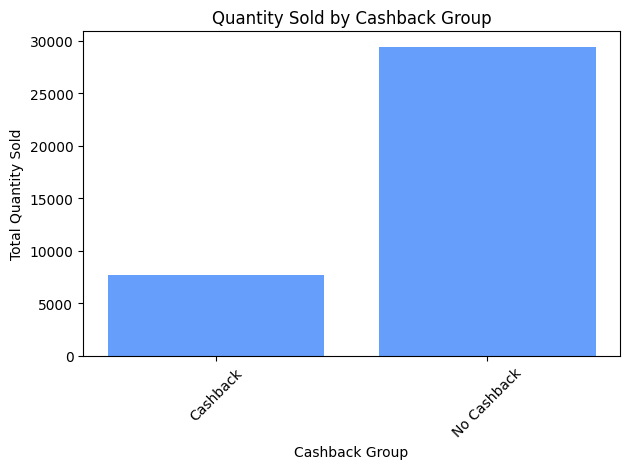

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count

# Assuming df_filtered is your initial DataFrame
grouped_df = df_filtered.groupBy(when(col("vnd_cashback") == 0, "No Cashback")
                                  .otherwise("Cashback").alias("cashback_group")) \
                        .agg(count("quantity_sold").alias("total_quantity"))

# Show the result
grouped_df.show()

# Collect the results into a list
results = grouped_df.collect()

# Extract data for plotting
cashback_groups = [row['cashback_group'] for row in results]
total_quantities = [row['total_quantity'] for row in results]

# Create a bar chart using matplotlib
plt.bar(cashback_groups, total_quantities, color=color_palette[2]) # Tiki Vietnam's brand colours
plt.title('Quantity Sold by Cashback Group')
plt.xlabel('Cashback Group')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
from pyspark.sql.functions import col, sum as _sum, desc
# Calculate the total quantity sold for each month
month_totals = df_filtered.groupBy("month").agg(_sum("quantity_sold").alias("total_quantity_sold"))

# Find the month with the highest total quantity sold
max_month = month_totals.orderBy(desc("total_quantity_sold")).limit(1)

# Show results
max_month.show()

+-----+-------------------+
|month|total_quantity_sold|
+-----+-------------------+
|    4|              87936|
+-----+-------------------+



/tmp/ipykernel_315200/2022407993.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


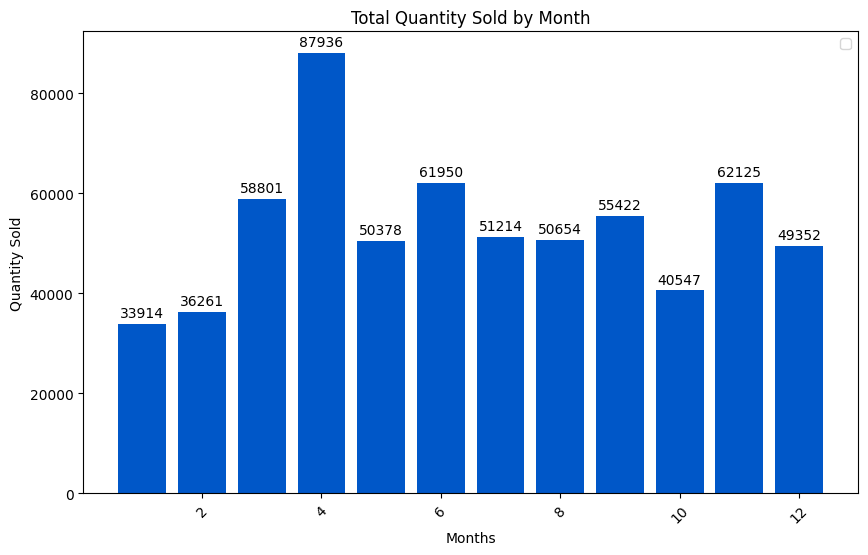

In [38]:
# 2. Total Quantity Sold For Each Month
quantity_by_month = df_filtered.groupBy("month").agg(_sum("quantity_sold").alias("total_quantity_sold"))
quantity_by_month = quantity_by_month.orderBy(desc("total_quantity_sold"))

# Collecting data for plotting
month = [row['month'] for row in quantity_by_month.collect()]
quantity_sold = [row['total_quantity_sold'] for row in quantity_by_month.collect()]

# Plotting Average Rating by Fulfillment Type
plt.figure(figsize=(10, 6))
plt.bar(month, quantity_sold, color=color_palette[3])
# Adding data labels
for i, txt in enumerate(quantity_sold):
    plt.annotate(f"{txt}", (month[i], quantity_sold[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.legend()
plt.ylabel('Quantity Sold')
plt.title('Total Quantity Sold by Month')
plt.xlabel('Months')
plt.xticks(rotation=45)
plt.show()

In [39]:
from pyspark.sql.functions import col, sum as _sum, desc
# Calculate the total quantity sold for each month
day_of_week_totals = df_filtered.groupBy("day_of_week").agg(_sum("quantity_sold").alias("total_quantity_sold"))

# Find the month with the highest total quantity sold
max_day_of_week = day_of_week_totals.orderBy(desc("total_quantity_sold")).limit(1)

# Show results
max_day_of_week.show()

+-----------+-------------------+
|day_of_week|total_quantity_sold|
+-----------+-------------------+
|        Thu|             129545|
+-----------+-------------------+



/tmp/ipykernel_315200/1347625263.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


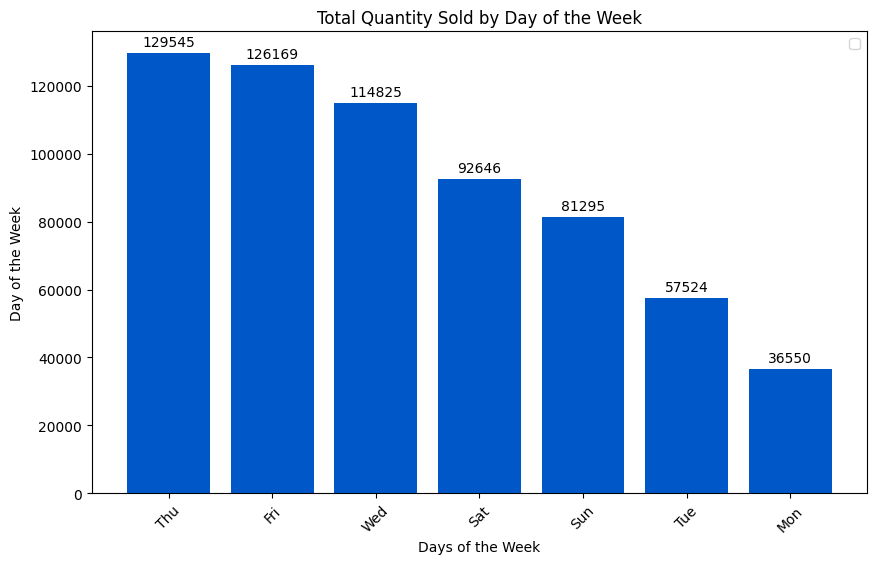

In [40]:
# 2. Total Quantity Sold For Each Month
quantity_by_day_of_week = df_filtered.groupBy("day_of_week").agg(_sum("quantity_sold").alias("total_quantity_sold"))
quantity_by_day_of_week = quantity_by_day_of_week.orderBy(desc("total_quantity_sold"))

# Collecting data for plotting
day_of_week = [row['day_of_week'] for row in quantity_by_day_of_week.collect()]
quantity_sold = [row['total_quantity_sold'] for row in quantity_by_day_of_week.collect()]

# Plotting Average Rating by Fulfillment Type
plt.figure(figsize=(10, 6))
plt.bar(day_of_week, quantity_sold, color=color_palette[3])

# Adding data labels
for i, txt in enumerate(quantity_sold):
    plt.annotate(f"{txt}", (day_of_week[i], quantity_sold[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.legend()
plt.ylabel('Day of the Week')
plt.xlabel('Days of the Week')
plt.title('Total Quantity Sold by Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [41]:
from pyspark.sql.functions import col, sum as _sum, desc
# Calculate the total quantity sold for each month
year_totals = df_filtered.groupBy("year").agg(_sum("quantity_sold").alias("total_quantity_sold"))

# Find the month with the highest total quantity sold
max_year = year_totals.orderBy(desc("total_quantity_sold")).limit(1)

# Show results
max_year.show()

+----+-------------------+
|year|total_quantity_sold|
+----+-------------------+
|2021|             185008|
+----+-------------------+



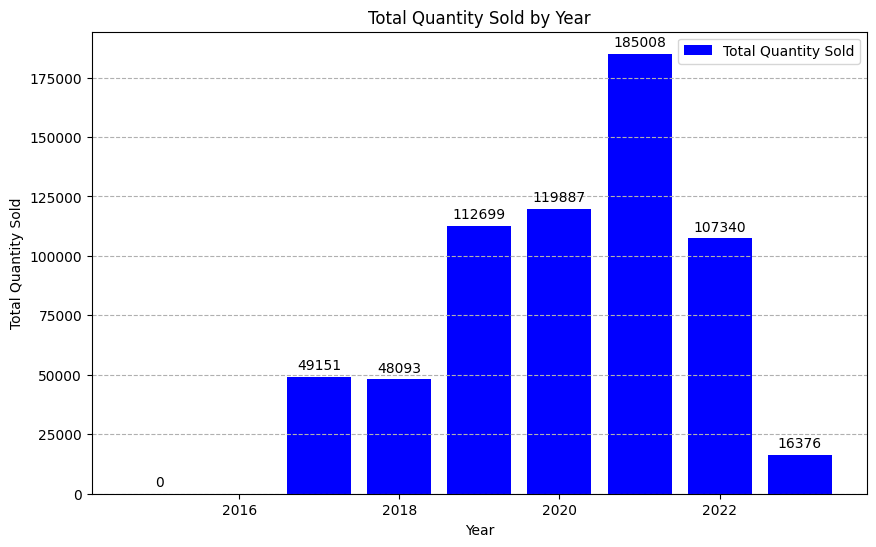

In [42]:
# 2. Total Quantity Sold For Each Year
quantity_by_year = df_filtered.groupBy("year").agg(_sum("quantity_sold").alias("total_quantity_sold"))
quantity_by_year = quantity_by_year.orderBy(desc("total_quantity_sold"))

# Collecting data for plotting
year = [row['year'] for row in quantity_by_year.collect()]
quantity_sold = [row['total_quantity_sold'] for row in quantity_by_year.collect()]

# Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(year, quantity_sold, color='b', label='Total Quantity Sold')

# Adding data labels
for i, txt in enumerate(quantity_sold):
    plt.annotate(f"{txt}", (year[i], quantity_sold[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Year')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Year')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

In [43]:
df_filtered.printSchema()

root
 |-- brand: string (nullable = true)
 |-- current_seller_cleaned: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)
 |-- price_difference: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- seller_product_count: long (nullable = true)
 |-- brand_product_count: long (nullable = true)
 |-- has_video_binary: integer (nullable = false)
 |-- pay_later_binary: integer (nullable = false)



In [44]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Use VectorAssembler to combine the selected numeric columns into one feature column
assembler = VectorAssembler(inputCols=["original_price", "price", "review_count", "date_created",
                                       "number_of_images", "vnd_cashback", "price_difference", "quantity_sold"],
                            outputCol="features")
df = assembler.transform(df_filtered)

In [45]:
# Compute the Pearson correlation matrix
r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.97377009, -0.02119476, -0.09867091,  0.06186664,
               0.25892611,  0.54828958, -0.01992391],
             [ 0.97377009,  1.        , -0.02605406, -0.09453179,  0.05061038,
               0.2538182 ,  0.34362373, -0.02178188],
             [-0.02119476, -0.02605406,  1.        ,  0.15410176,  0.02727528,
              -0.00949839,  0.00828249,  0.59418803],
             [-0.09867091, -0.09453179,  0.15410176,  1.        , -0.14659976,
              -0.08364412, -0.05980079,  0.12383882],
             [ 0.06186664,  0.05061038,  0.02727528, -0.14659976,  1.        ,
               0.0879391 ,  0.06932822,  0.00145806],
             [ 0.25892611,  0.2538182 , -0.00949839, -0.08364412,  0.0879391 ,
               1.        ,  0.13577813, -0.01029777],
             [ 0.54828958,  0.34362373,  0.00828249, -0.05980079,  0.06932822,
               0.13577813,  1.        , -0.00217439],
             [-0.01992391, -0.02178188,  

24/12/14 10:21:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [46]:
# Compute the Spearman correlation matrix
r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

24/12/14 10:21:59 WARN Executor: Managed memory leak detected; size = 15730412 bytes, task 0.0 in stage 463.0 (TID 232)
24/12/14 10:22:00 WARN Executor: Managed memory leak detected; size = 15730412 bytes, task 0.0 in stage 473.0 (TID 234)


Spearman correlation matrix:
DenseMatrix([[ 1.        ,  0.98984544,  0.00864464, -0.05356154,  0.11880594,
               0.13192649,  0.25816627, -0.0594563 ],
             [ 0.98984544,  1.        , -0.01623356, -0.05248519,  0.10797394,
               0.11541815,  0.15792185, -0.0848945 ],
             [ 0.00864464, -0.01623356,  1.        ,  0.33531939,  0.01888212,
               0.00560205,  0.17021387,  0.81120588],
             [-0.05356154, -0.05248519,  0.33531939,  1.        , -0.15018041,
              -0.04836867,  0.01778333,  0.34791539],
             [ 0.11880594,  0.10797394,  0.01888212, -0.15018041,  1.        ,
               0.10781802,  0.09522033,  0.01481535],
             [ 0.13192649,  0.11541815,  0.00560205, -0.04836867,  0.10781802,
               1.        ,  0.23138518, -0.01319339],
             [ 0.25816627,  0.15792185,  0.17021387,  0.01778333,  0.09522033,
               0.23138518,  1.        ,  0.16305738],
             [-0.0594563 , -0.0848945 , 

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector

# Extract the Pearson and Spearman correlation matrices
pearson_matrix = r1[0].toArray()  # This is the Pearson correlation matrix
spearman_matrix = r2[0].toArray()  # This is the Spearman correlation matrix

# List of feature column names
feature_columns = ["original_price", "price", "review_count", "date_created",
                                       "number_of_images", "vnd_cashback", "price_difference", "quantity_sold"]

# Create a DataFrame for the Pearson correlation matrix
# Convert to numpy array for easy manipulation and plotting
pearson_matrix = np.array(pearson_matrix)

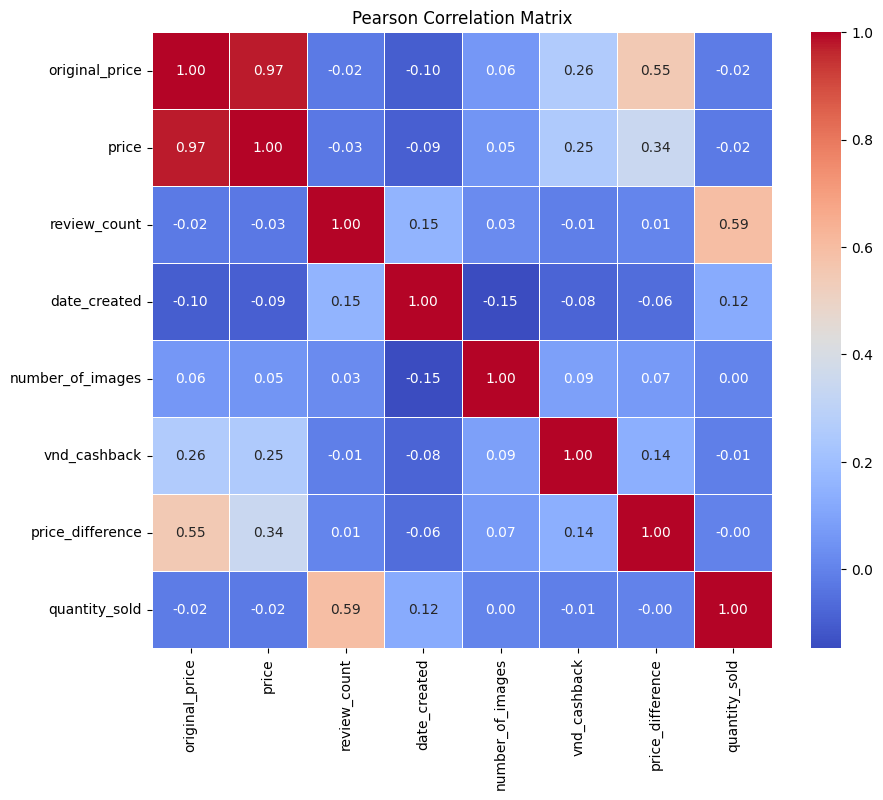

In [48]:
# Create a heatmap using seaborn to visualize the Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_matrix, xticklabels=feature_columns, yticklabels=feature_columns,
            cmap='coolwarm', annot=True, fmt=".2f", cbar=True, linecolor='white', linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()

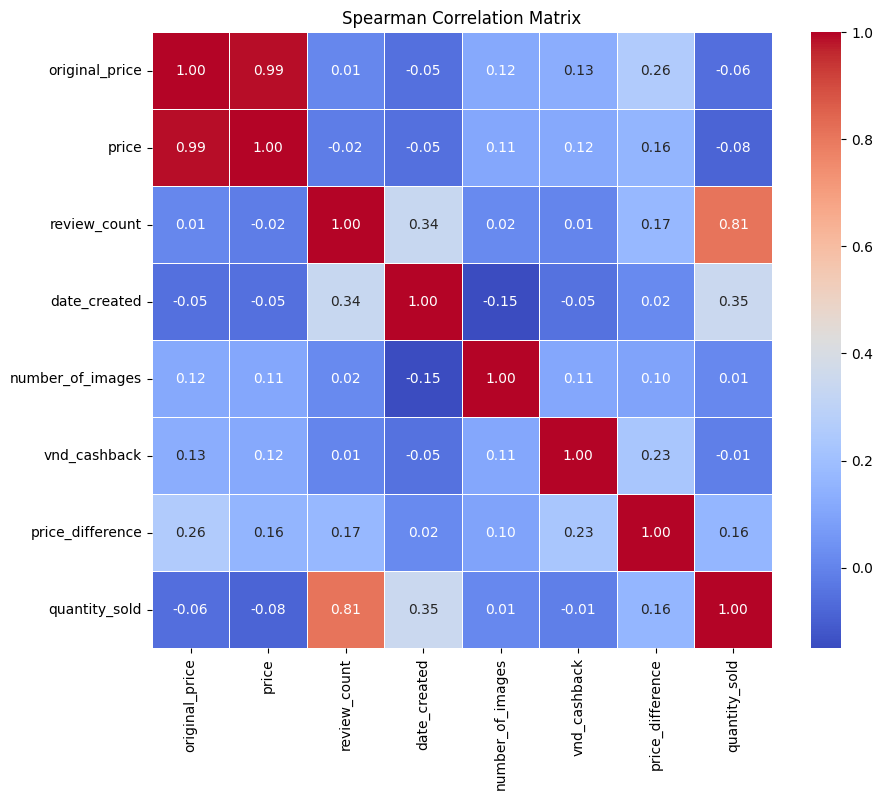

In [49]:
# Create a heatmap using seaborn to visualize the Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_matrix, xticklabels=feature_columns, yticklabels=feature_columns,
            cmap='coolwarm', annot=True, fmt=".2f", cbar=True, linecolor='white', linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

In [50]:
import numpy as np
# Convert the correlation matrix to a numpy array
# Extract the correlation matrix (DenseVector)
corr_matrix = r1[0].toArray()  # Convert DenseVector to a NumPy array

# Set the limit for strong positive correlations
limit = 0.50

# Get the number of features
num_features = corr_matrix.shape[0]

# Flag to track if any strong correlations were found
strong_corr_found = False

# Iterate through the matrix and print pairs of columns with high correlations
for i in range(num_features):
    for j in range(i + 1, num_features):  # Avoid duplicates (i.e., (i, j) and (j, i))
        corr_value = corr_matrix[i, j]
        if abs(corr_value) > limit:  # Check if absolute correlation exceeds the limit
            print(f"Strong correlation between {feature_columns[i]} and {feature_columns[j]}: {corr_value}")
            strong_corr_found = True

# If no strong correlations are found, print a message
if not strong_corr_found:
    print("No strong positive correlations present.")

Strong correlation between original_price and price: 0.9737700863090182
Strong correlation between original_price and price_difference: 0.5482895766866571
Strong correlation between review_count and quantity_sold: 0.5941880307309251


In [51]:
import numpy as np
# Convert the correlation matrix to a numpy array
# Extract the correlation matrix (DenseVector)
corr_matrix = r1[0].toArray()  # Convert DenseVector to a NumPy array

# Set the limit for strong correlations
limit = -0.50

# Get the number of features
num_features = corr_matrix.shape[0]

# Flag to track if any strong correlations were found
strong_corr_found = False

# Iterate through the matrix and print pairs of columns with high correlations
for i in range(num_features):
    for j in range(i + 1, num_features):  # Avoid duplicates (i.e., (i, j) and (j, i))
        corr_value = corr_matrix[i, j]
        if abs(corr_value) < limit:  # Check if absolute correlation exceeds the limit
            print(f"Strong correlation between {feature_columns[i]} and {feature_columns[j]}: {corr_value}")
            strong_corr_found = True

# If no strong correlations are found, print a message
if not strong_corr_found:
    print("No strong negative correlations present.")

No strong negative correlations present.


Since the correlation is so high (0.97) between original_price and price, it could suggests that the price is often closely tied to the original_price. And this is likely because most of the time, the price is either the same as the original_price and not many discounts are applied (if no discount is applied) or a percentage-based reduction. And hence from this I'd like to explore and analyze the impact of discounts on customer behaviour and product demand.

The output "Strong correlation between review_count and quantity_sold: 0.6038754154146274" implies that products with more reviews tend to have higher sales. From this, I'd like to explore if enhancing review visibility or encouraging reviews could further increase sales, or whether other factors contribute to sales more strongly.

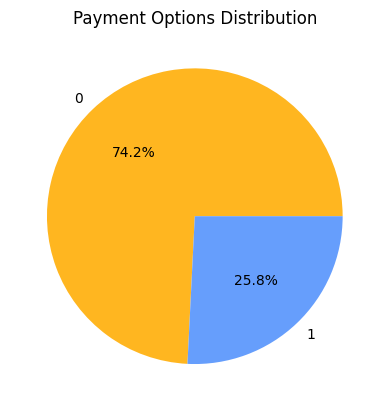

In [52]:
# 2. Average Rating by Fulfillment Type
pay_later_quantity = df_filtered.groupBy("pay_later_binary").agg(_sum("quantity_sold").alias("total_quantity_sold"))
pay_later_quantity = pay_later_quantity.orderBy(desc("total_quantity_sold"))

# Collecting data for plotting
pay_later_binary = [row['pay_later_binary'] for row in pay_later_quantity.collect()]
total_quantity_sold = [row['total_quantity_sold'] for row in pay_later_quantity.collect()]

# Choose specific colors from the palette
specific_colors = [color_palette[1], color_palette[2]]  # 2nd and 4th colors

# Plotting pie chart
plt.pie(total_quantity_sold, labels=pay_later_binary, autopct='%1.1f%%', colors=specific_colors)
plt.title('Payment Options Distribution')
plt.show()

In [53]:
# Not Helpful
# # Group by video presence and sum quantity sold
# video_sales = df_filtered.groupBy("has_video_binary").agg(_sum("quantity_sold").alias("total_quantity_sold"))
# video_sales = video_sales.orderBy(desc("total_quantity_sold"))

# # Collecting data for plotting
# has_video_binary = [row['has_video_binary'] for row in video_sales.collect()]
# total_quantity_sold = [row['total_quantity_sold'] for row in video_sales.collect()]

# # Choose specific colors from the palette
# specific_colors = [color_palette[1], color_palette[2]]  # 2nd and 4th colors

# # Plotting pie chart
# plt.pie(total_quantity_sold, labels=has_video_binary, autopct='%1.1f%%', colors=specific_colors)
# plt.title('Impact of Video Presence on Sales')
# plt.show()

In [54]:
df_filtered = df_filtered.drop("current_seller", "day_of_week", "month", "year")
df_filtered.show()

+---------+----------------------+--------------+------+----------------+------------+--------------+------------+----------------+------------+-------------------+-------------+----------------+--------------------+-------------------+----------------+----------------+
|    brand|current_seller_cleaned|original_price| price|fulfillment_type|review_count|rating_average|date_created|number_of_images|vnd_cashback|       product_type|quantity_sold|price_difference|seller_product_count|brand_product_count|has_video_binary|pay_later_binary|
+---------+----------------------+--------------+------+----------------+------------+--------------+------------+----------------+------------+-------------------+-------------+----------------+--------------------+-------------------+----------------+----------------+
|   Laceva|  laceva official s...|        129000|129000|   tiki_delivery|         969|           4.6|        1034|               7|        3453|          men_shoes|         2894|         

In [55]:
df_filtered.printSchema()

root
 |-- brand: string (nullable = true)
 |-- current_seller_cleaned: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)
 |-- price_difference: integer (nullable = true)
 |-- seller_product_count: long (nullable = true)
 |-- brand_product_count: long (nullable = true)
 |-- has_video_binary: integer (nullable = false)
 |-- pay_later_binary: integer (nullable = false)



In [56]:
# Total number of rows
df_filtered_num_rows = df_filtered.count()

# Total number of columns
df_filtered_num_columns = len(df_filtered.columns)

# Print the results
print(f"Total number of rows: {df_filtered_num_rows}")
print(f"Total number of columns: {df_filtered_num_columns}")

Total number of rows: 37125
Total number of columns: 17


### Step 3: Train Test Split

In [57]:
# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df_filtered.randomSplit([0.8, 0.2], seed=42)

In [58]:
# Impute missing values for rating_average if any exist
imputer = Imputer(
    inputCols=['rating_average'], 
    outputCols=["rating_average_imputed"]
).setStrategy("median")

In [59]:
# Add imputation columns to DataFrame
imputation = imputer.fit(train_data)

In [60]:
train_impute = imputation.transform(train_data)
test_impute = imputation.transform(test_data)

In [61]:
# Drop the original rating_average column if no longer needed
train_impute = train_impute.drop("rating_average")
test_impute = test_impute.drop("rating_average")

### Step 4: Data Wrangling and Transformation

#### Logarithmic Transformation (experimented with, but unused)

In [62]:
# from pyspark.sql.functions import log1p

# # List of columns to apply log transformation
# columns_to_transform = ['original_price', 'price']

# # Function to apply log1p transformation to a DataFrame
# def apply_log_transformation(df, columns):
#     for col in columns:
#         if col in df.columns:  # Check if column exists in DataFrame
#             df = df.withColumn(f'log_{col}', log1p(df[col]))
#         else:
#             print(f"Warning: Column '{col}' not found in DataFrame.")
#     return df

# # Apply the log transformation to both train and test datasets
# train_transformed = apply_log_transformation(train_impute, columns_to_transform)
# test_transformed = apply_log_transformation(test_impute, columns_to_transform)

# # Show some rows to verify the transformation for the train dataset
# print("Transformed Training Dataset:")
# train_transformed.select([f'log_{col}' for col in columns_to_transform]).show()

# # Show some rows to verify the transformation for the test dataset
# print("Transformed Testing Dataset:")
# test_transformed.select([f'log_{col}' for col in columns_to_transform]).show()

In [63]:
# train_transformed.show(5)

In [64]:
# # Drop the original rating_average column if no longer needed
# train_transformed = train_transformed.drop('original_price', 'price')
# test_transformed = test_transformed.drop('original_price', 'price')

In [65]:
# # Total number of rows
# train_transformed_num_rows = train_transformed.count()

# # Total number of columns
# train_transformed_num_columns = len(train_transformed.columns)

# # Print the results
# print(f"Total number of rows: {train_transformed_num_rows}")
# print(f"Total number of columns: {train_transformed_num_columns}")

In [66]:
# # Total number of rows
# test_transformed_num_rows = test_transformed.count()

# # Total number of columns
# test_transformed_num_columns = len(test_transformed.columns)

# # Print the results
# print(f"Total number of rows: {test_transformed_num_rows}")
# print(f"Total number of columns: {test_transformed_num_columns}")

In [67]:
# # Print the results
# print(f"Total number of rows: {train_transformed_num_rows + test_transformed_num_rows}")
# print(f"Total number of columns: {train_transformed_num_columns + test_transformed_num_columns}")

#### Yeo-Johnson Transformation (experimented with, but unused)

In [68]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import DoubleType
# import numpy as np

# # Define the Yeo-Johnson transformation function
# def yeo_johnson_transformation(x, lambda_val=0.5):
#     """
#     Apply Yeo-Johnson transformation to a single value 'x'.
#     """
#     if x is None:  # Handle None or null values
#         return None

#     if x > 0:
#         if lambda_val == 0:
#             return np.log(x)
#         else:
#             return (x ** lambda_val - 1) / lambda_val
#     elif x <= 0:
#         if lambda_val == 2:
#             return -np.log(-x + 1)
#         else:
#             return -( (-x + 1) ** (2 - lambda_val) - 1) / (2 - lambda_val)

# # Create a UDF from the Yeo-Johnson transformation function
# yeo_johnson_udf = udf(yeo_johnson_transformation, DoubleType())

# # Define the columns to transform (make sure this list is defined)
# columns_to_transform = ["original_price", "price", "review_count", 
#     "vnd_cashback", "price_difference", "date_created", "number_of_images"
# ]

# # Function to apply log1p transformation to a DataFrame
# def apply_yeojohn_transformation(df, columns):
#     for col in columns:
#         if col in df.columns:  # Check if column exists in DataFrame
#             df = df.withColumn(f"{col}_transformed", yeo_johnson_udf(df[col]))
#         else:
#             print(f"Warning: Column '{col}' not found in DataFrame.")
#     return df

# # Apply the log transformation to both train and test datasets
# train_transformed = apply_yeojohn_transformation(train_encoded, columns_to_transform)

# # Apply the log transformation to both train and test datasets
# test_transformed = apply_yeojohn_transformation(test_encoded, columns_to_transform)

In [69]:
# # Show the transformed DataFrame
# train_transformed.show()

In [70]:
# # Show the transformed DataFrame
# test_transformed.show()

In [71]:
# # Drop the original rating_average column if no longer needed
# train_transformed = train_transformed.drop("original_price", "price", "review_count",
#                                            "price_difference")
# test_transformed = test_transformed.drop("original_price", "price", "review_count",
#                                            "price_difference")

In [72]:
# # Total number of rows
# train_transformed_num_rows = train_transformed.count()

# # Total number of columns
# train_transformed_num_columns = len(train_transformed.columns)

# # Print the results
# print(f"Total number of rows: {train_transformed_num_rows}")
# print(f"Total number of columns: {train_transformed_num_columns}")

In [73]:
# # Total number of rows
# test_transformed_num_rows = test_transformed.count()

# # Total number of columns
# test_transformed_num_columns = len(test_transformed.columns)

# # Print the results
# print(f"Total number of rows: {test_transformed_num_rows}")
# print(f"Total number of columns: {test_transformed_num_columns}")

In [74]:
# # Print the results
# print(f"Total number of rows: {train_transformed_num_rows + test_transformed_num_rows}")
# print(f"Total number of columns: {train_transformed_num_columns + test_transformed_num_columns}")

#### Square Root Transformation (experimented with, but unused)

In [75]:
# from pyspark.sql.functions import sqrt, col

# # List of columns you want to apply the transformation to
# columns_to_transform = ["original_price", "price", "review_count", "price_difference"]

# # Apply square root transformation to each column in both train_df and test_df
# for column in columns_to_transform:
#     # Apply transformation to train_df
#     train_transformed = train_encoded.withColumn(f"{column}_transformed", sqrt(col(column)))
    
#     # Apply the same transformation to test_df
#     test_transformed = test_encoded.withColumn(f"{column}_transformed", sqrt(col(column)))

# # Show the updated DataFrames (train and test)
# train_transformed.show()
# test_transformed.show()

In [76]:
# # Total number of rows
# train_transformed_num_rows = train_transformed.count()

# # Total number of columns
# train_transformed_num_columns = len(train_transformed.columns)

# # Print the results
# print(f"Total number of rows: {train_transformed_num_rows}")
# print(f"Total number of columns: {train_transformed_num_columns}")

In [77]:
# # Total number of rows
# test_transformed_num_rows = test_transformed.count()

# # Total number of columns
# test_transformed_num_columns = len(test_transformed.columns)

# # Print the results
# print(f"Total number of rows: {test_transformed_num_rows}")
# print(f"Total number of columns: {test_transformed_num_columns}")

### Encoding

In [79]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Define columns for StringIndexer and OneHotEncoder
string_columns = ["current_seller_cleaned", "brand"]
encoding_columns = ["fulfillment_type", "product_type"]

# Create StringIndexer stages for the string columns with handleInvalid='keep'
string_indexer_stages = [
    StringIndexer(inputCol=col, outputCol=col + "_string_encoded", handleInvalid='keep') for col in string_columns
]

# Create StringIndexer stages for the fulfillment_type and product_type columns with handleInvalid='keep'
encoding_indexer_stages = [
    StringIndexer(inputCol=col, outputCol=col + "_string_encoded", handleInvalid='keep') for col in encoding_columns
]

# Create OneHotEncoder stages for the encoded fulfillment_type and product_type columns
one_hot_encoder_stages = [
    OneHotEncoder(inputCol=col + "_string_encoded", outputCol=col + "_one_hot") for col in encoding_columns
]

# Combine all stages into a single pipeline (index first, then encode)
pipeline_stages = string_indexer_stages + encoding_indexer_stages + one_hot_encoder_stages
pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline model on the training data
pyspark_pipeline_model = pipeline.fit(train_impute)

# Transform the training dataset using the fitted pipeline
train_encoded = pyspark_pipeline_model.transform(train_impute)

# Transform the testing dataset using the fitted pipeline
test_encoded = pyspark_pipeline_model.transform(test_impute)

In [80]:
# Drop the original rating_average column if no longer needed
train_encoded = train_encoded.drop("current_seller_cleaned", "brand", "fulfillment_type", "product_type")
test_encoded = test_encoded.drop("current_seller_cleaned", "brand", "fulfillment_type", "product_type")

In [81]:
# Total number of rows
train_encoded_num_rows = train_encoded.count()

# Total number of columns
train_encoded_num_columns = len(train_encoded.columns)

# Print the results
print(f"Total number of rows: {train_encoded_num_rows}")
print(f"Total number of columns: {train_encoded_num_columns}")

Total number of rows: 29709
Total number of columns: 19


In [82]:
# Total number of rows
test_encoded_num_rows = test_encoded.count()

# Total number of columns
test_encoded_num_columns = len(test_encoded.columns)

# Print the results
print(f"Total number of rows: {test_encoded_num_rows}")
print(f"Total number of columns: {test_encoded_num_columns}")

Total number of rows: 7416
Total number of columns: 19


In [83]:
# Print the results
print(f"Total number of rows: {train_encoded_num_rows + test_encoded_num_rows}")
print(f"Total number of columns: {train_encoded_num_columns + test_encoded_num_columns}")

Total number of rows: 37125
Total number of columns: 38


In [84]:
from pyspark.ml.feature import VectorAssembler

# Replace 'quantity_sold' with the actual name of your target variable if different
target_column = "quantity_sold"

# Function to create a VectorAssembler and transform the dataset
def vectorize_data(encoded_data, target_col):
    # Determine input features by excluding the target column
    input_features = [col for col in encoded_data.columns if col != target_col]

    # Print the input features to check if the target column is excluded
    print(f"Input features (excluding '{target_col}'):", input_features)

    # Create a VectorAssembler to transform the features
    feature_assembler = VectorAssembler(inputCols=input_features, outputCol="Xcols")

    # Apply the VectorAssembler to the dataset
    vectored_data = feature_assembler.transform(encoded_data)

    return vectored_data

# Apply vectorization to the training and testing data
train_vectored = vectorize_data(train_encoded, target_column)
test_vectored = vectorize_data(test_encoded, target_column)

Input features (excluding 'quantity_sold'): ['original_price', 'price', 'review_count', 'date_created', 'number_of_images', 'vnd_cashback', 'price_difference', 'seller_product_count', 'brand_product_count', 'has_video_binary', 'pay_later_binary', 'rating_average_imputed', 'current_seller_cleaned_string_encoded', 'brand_string_encoded', 'fulfillment_type_string_encoded', 'product_type_string_encoded', 'fulfillment_type_one_hot', 'product_type_one_hot']
Input features (excluding 'quantity_sold'): ['original_price', 'price', 'review_count', 'date_created', 'number_of_images', 'vnd_cashback', 'price_difference', 'seller_product_count', 'brand_product_count', 'has_video_binary', 'pay_later_binary', 'rating_average_imputed', 'current_seller_cleaned_string_encoded', 'brand_string_encoded', 'fulfillment_type_string_encoded', 'product_type_string_encoded', 'fulfillment_type_one_hot', 'product_type_one_hot']


In [85]:
# Total number of rows
train_vectored_num_rows = train_vectored.count()

# Total number of columns
train_vectored_num_columns = len(train_vectored.columns)

# Print the results
print(f"Total number of rows: {train_vectored_num_rows}")
print(f"Total number of columns: {train_vectored_num_columns}")

Total number of rows: 29709
Total number of columns: 20


In [86]:
# Total number of rows
test_vectored_num_rows = test_vectored.count()

# Total number of columns
test_vectored_num_columns = len(test_vectored.columns)

# Print the results
print(f"Total number of rows: {test_vectored_num_rows}")
print(f"Total number of columns: {test_vectored_num_columns}")

Total number of rows: 7416
Total number of columns: 20


In [87]:
# Print the results
print(f"Total number of rows: {train_vectored_num_rows + test_vectored_num_rows}")
print(f"Total number of columns: {train_vectored_num_columns + test_vectored_num_columns}")

Total number of rows: 37125
Total number of columns: 40


### Robust Scaler Linear Regression Model 

In [88]:
from pyspark.ml.feature import RobustScaler

RobustsScaler = RobustScaler(inputCol="Xcols", outputCol="Xcols_sscaled")

In [89]:
# Fit the scaler model on the training data
scaler_model = RobustsScaler.fit(train_vectored)

# Step 4: Transform the training and testing datasets
train_scaled = scaler_model.transform(train_vectored)
test_scaled = scaler_model.transform(test_vectored)

# Optionally, print the scaled feature columns to verify
print("Training data scaled features:")
train_scaled.select("Xcols_sscaled").show(truncate=False)

print("Testing data scaled features:")
test_scaled.select("Xcols_sscaled").show(truncate=False)

Training data scaled features:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Xcols_sscaled                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(25,[0,1,3,4,7,8,10,12,13,15,16,21],[0.5979899497487438,0.695906432748538,1.1912442396313363,0.5,1.1481481481481481,2.188662727073758E-4,1.0,0.0794392523364486,259.0,0.6666666666666666,0.0,0.0])                   |
|(25,[0,1,3,4,7,8,10,12,13,15,16,21],[0.6984924623115578,0.8128654970760234,1.2165898617511521,0.5,1.1481

In [90]:
# Select relevant columns for training and testing datasets
train_data = train_scaled.select("Xcols_sscaled", "quantity_sold")
train_data.show(10)

test_data = test_scaled.select("Xcols_sscaled", "quantity_sold")
test_data.show(10)

+--------------------+-------------+
|       Xcols_sscaled|quantity_sold|
+--------------------+-------------+
|(25,[0,1,3,4,7,8,...|            0|
|(25,[0,1,3,4,7,8,...|            0|
|(25,[0,1,2,3,4,7,...|            8|
|(25,[0,1,3,4,7,8,...|            0|
|(25,[0,1,3,4,7,8,...|            0|
|(25,[0,1,2,3,4,5,...|            9|
|(25,[0,1,2,3,4,5,...|          283|
|(25,[0,1,2,3,4,5,...|          102|
|(25,[0,1,2,3,4,5,...|          728|
|(25,[0,1,2,3,4,5,...|           11|
+--------------------+-------------+
only showing top 10 rows

+--------------------+-------------+
|       Xcols_sscaled|quantity_sold|
+--------------------+-------------+
|(25,[0,1,2,3,4,6,...|            1|
|(25,[0,1,3,4,7,8,...|            2|
|(25,[0,1,2,3,4,5,...|           65|
|[0.30150753768844...|           16|
|[0.87939698492462...|         1478|
|[0.95477386934673...|          469|
|[1.30653266331658...|            3|
|(25,[0,1,2,3,4,6,...|          165|
|[1.50251256281407...|           10|
|(25,[0,1,3,

In [91]:
# Total number of rows
train_data_num_rows = train_scaled.count()

# Total number of columns
train_data_num_columns = len(train_scaled.columns)

# Print the results
print(f"Total number of rows: {train_data_num_rows}")
print(f"Total number of columns: {train_data_num_columns}")

Total number of rows: 29709
Total number of columns: 21


In [92]:
# Total number of rows
test_data_num_rows = test_data.count()

# Total number of columns
test_data_num_columns = len(test_data.columns)

# Print the results
print(f"Total number of rows: {test_data_num_rows}")
print(f"Total number of columns: {test_data_num_columns}")

Total number of rows: 7416
Total number of columns: 2


In [93]:
# Print the results
print(f"Total number of rows: {train_data_num_rows + test_data_num_rows}")
print(f"Total number of columns: {train_data_num_columns + test_data_num_columns}")

Total number of rows: 37125
Total number of columns: 23


In [94]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
regressor = LinearRegression(featuresCol="Xcols_sscaled", labelCol='quantity_sold')

# Fit the model on the training data
regressor_model = regressor.fit(train_data)

# Display the type of the fitted model
print("Fitted model type:", type(regressor_model))

# Coefficients
print("Coefficients:", regressor_model.coefficients)

# Intercept
print("Intercept:", regressor_model.intercept)

# Evaluate the model on the training data
train_pred_results = regressor_model.evaluate(train_data)
print("Training Predictions:")
train_pred_results.predictions.show()

# Evaluate the model on the testing data
test_pred_results = regressor_model.evaluate(test_data)
print("Testing Predictions:")
test_pred_results.predictions.show()

# Print evaluation metrics for training data
train_metrics = (train_pred_results.meanAbsoluteError, 
                 train_pred_results.meanSquaredError, 
                 train_pred_results.r2)
print("Training Metrics - MAE: {}, MSE: {}, R2: {}".format(*train_metrics))

# Print evaluation metrics for testing data
test_metrics = (test_pred_results.meanAbsoluteError, 
                test_pred_results.meanSquaredError, 
                test_pred_results.r2)
print("Testing Metrics - MAE: {}, MSE: {}, R2: {}".format(*test_metrics))

24/12/14 10:22:22 WARN Instrumentation: [acf2cc0b] regParam is zero, which might cause numerical instability and overfitting.
24/12/14 10:22:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/12/14 10:22:22 WARN Instrumentation: [acf2cc0b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Fitted model type: <class 'pyspark.ml.regression.LinearRegressionModel'>
Coefficients: [-0.6759139671715381,0.6498400798266053,5.646996213870872,6.44716200378527,-1.7112901508555465,0.0,0.0,-0.8812797354490541,-3.255283277653636,0.0,-10.486737606939158,-6.430820362597643,-0.1640575554823906,0.006469620923165895,0.0,4.332048131241905,0.0,0.0,0.0,2.449185482333334,0.0,0.0,0.0,0.0,0.0]
Intercept: -0.349314227128566
Training Predictions:
+--------------------+-------------+-------------------+
|       Xcols_sscaled|quantity_sold|         prediction|
+--------------------+-------------+-------------------+
|(25,[0,1,3,4,7,8,...|            0|-0.4254350488974998|
|(25,[0,1,3,4,7,8,...|            0|-0.2539540812823448|
|(25,[0,1,2,3,4,7,...|            8|  7.278664124934867|
|(25,[0,1,3,4,7,8,...|            0|  14.50098880817364|
|(25,[0,1,3,4,7,8,...|            0|   8.77083603939083|
|(25,[0,1,2,3,4,5,...|            9|  4.271764388259547|
|(25,[0,1,2,3,4,5,...|          283|  255.8882231

### Decision Tree Regressor Model using Robust Scaler

In [95]:
from pyspark.ml.regression import DecisionTreeRegressor
# Initialize the Decision Tree Regressor
decision_tree_regressor1 = DecisionTreeRegressor(featuresCol='Xcols_sscaled', labelCol='quantity_sold')
# Fit the model on the training data
decision_tree_regressor_model1 = decision_tree_regressor1.fit(train_data)

# Make predictions on test data
predictions = decision_tree_regressor_model1.transform(test_data)

# Evaluate performance using RMSE and R2 metrics
evaluator_rmse = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
evaluator_r2 = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}, R2: {r2}")

# Show a sample of predictions along with actual values
predictions.select("quantity_sold", "prediction").show(10)

RMSE: 66.10169793450592, R2: 0.5692930854719668
+-------------+------------------+
|quantity_sold|        prediction|
+-------------+------------------+
|            1| 5.756580661975502|
|            2| 6.467741935483871|
|           65|22.211180124223603|
|           16|30.325581395348838|
|         1478| 268.4170403587444|
|          469| 268.4170403587444|
|            3| 5.756580661975502|
|          165|30.325581395348838|
|           10| 5.756580661975502|
|            3|0.9473631542079456|
+-------------+------------------+
only showing top 10 rows



### Decision Tree Regressor with Robust Scaler and Cross Validation

In [96]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree_regressor3 = DecisionTreeRegressor(featuresCol='Xcols_sscaled', labelCol='quantity_sold')

# Create a parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(decision_tree_regressor3.maxDepth, [2, 5, 7, 10, 13, 15, 17, 19, 22])  # Example depths
             .addGrid(decision_tree_regressor3.minInstancesPerNode, [2, 5, 7, 10, 13, 15, 17, 19, 22])  # Example instances
             .addGrid(decision_tree_regressor3.impurity, ["variance"])  # Example impurity measures
             .build())

# Set up CrossValidator
crossval = CrossValidator(estimator=decision_tree_regressor3,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse"),
                          numFolds=5)  # Use 5+ folds for cross-validation

# Fit the model using cross-validation
cvModel2 = crossval.fit(train_data)

# Make predictions on test data
predictions = cvModel2.transform(test_data)

# Evaluate performance
evaluator_rmse = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}, R²: {r2}")

# Show predictions
predictions.select("quantity_sold", "prediction").show(10)

24/12/14 10:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1131.8 KiB
24/12/14 10:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1131.8 KiB
24/12/14 10:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1281.0 KiB
24/12/14 10:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1432.6 KiB
24/12/14 10:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1042.8 KiB
24/12/14 10:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB
24/12/14 10:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1131.8 KiB
24/12/14 10:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1281.0 KiB
24/12/14 10:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1432.6 KiB
24/12/14 10:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1578.1 KiB
24/12/14 10:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1721.6 KiB
24/12/14 10:24:49 WAR

RMSE: 71.005455904605, R²: 0.5030186928852578
+-------------+-----------------+
|quantity_sold|       prediction|
+-------------+-----------------+
|            1|4.019803421914816|
|            2|4.019803421914816|
|           65|4.019803421914816|
|           16|4.019803421914816|
|         1478|401.8068181818182|
|          469|401.8068181818182|
|            3|4.019803421914816|
|          165|4.019803421914816|
|           10|4.019803421914816|
|            3|4.019803421914816|
+-------------+-----------------+
only showing top 10 rows



### Standard Scaler Linear Regression Model

In [97]:
from pyspark.ml.feature import StandardScaler

StandardsScaler = StandardScaler(inputCol="Xcols", outputCol="Xcols_standardsscaled")

In [98]:
# Fit the scaler model on the training data
scaler_model = StandardsScaler.fit(train_vectored)

# Step 4: Transform the training and testing datasets
train_Standardscaled = scaler_model.transform(train_vectored)
test_Standardscaled = scaler_model.transform(test_vectored)

# Optionally, print the scaled feature columns to verify
print("Training data scaled features:")
train_Standardscaled.select("Xcols_standardsscaled").show(truncate=False)

print("Testing data scaled features:")
test_Standardscaled.select("Xcols_standardsscaled").show(truncate=False)

Training data scaled features:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Xcols_standardsscaled                                                                                                                                                                                                                                                                                                                                                  |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [99]:
# Select relevant columns for training and testing datasets
train_data = train_Standardscaled.select("Xcols_standardsscaled", "quantity_sold")
train_data.show(10)

test_data = test_Standardscaled.select("Xcols_standardsscaled", "quantity_sold")
test_data.show(10)

+---------------------+-------------+
|Xcols_standardsscaled|quantity_sold|
+---------------------+-------------+
| (25,[0,1,3,4,7,8,...|            0|
| (25,[0,1,3,4,7,8,...|            0|
| (25,[0,1,2,3,4,7,...|            8|
| (25,[0,1,3,4,7,8,...|            0|
| (25,[0,1,3,4,7,8,...|            0|
| (25,[0,1,2,3,4,5,...|            9|
| (25,[0,1,2,3,4,5,...|          283|
| (25,[0,1,2,3,4,5,...|          102|
| (25,[0,1,2,3,4,5,...|          728|
| (25,[0,1,2,3,4,5,...|           11|
+---------------------+-------------+
only showing top 10 rows

+---------------------+-------------+
|Xcols_standardsscaled|quantity_sold|
+---------------------+-------------+
| (25,[0,1,2,3,4,6,...|            1|
| (25,[0,1,3,4,7,8,...|            2|
| (25,[0,1,2,3,4,5,...|           65|
| [0.07089611631266...|           16|
| [0.20678033924525...|         1478|
| [0.22450436832342...|          469|
| [0.30721650402152...|            3|
| (25,[0,1,2,3,4,6,...|          165|
| [0.35329897962475...| 

In [100]:
# Total number of rows
train_data_num_rows = train_data.count()

# Total number of columns
train_data_num_columns = len(train_data.columns)

# Print the results
print(f"Total number of rows: {train_data_num_rows}")
print(f"Total number of columns: {train_data_num_columns}")

Total number of rows: 29709
Total number of columns: 2


In [101]:
# Total number of rows
test_data_num_rows = test_data.count()

# Total number of columns
test_data_num_columns = len(test_data.columns)

# Print the results
print(f"Total number of rows: {test_data_num_rows}")
print(f"Total number of columns: {test_data_num_columns}")

Total number of rows: 7416
Total number of columns: 2


In [102]:
# Print the results
print(f"Total number of rows: {train_data_num_rows + test_data_num_rows}")
print(f"Total number of columns: {train_data_num_columns + test_data_num_columns}")

Total number of rows: 37125
Total number of columns: 4


In [103]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
regressor = LinearRegression(featuresCol="Xcols_standardsscaled", labelCol='quantity_sold')

# Fit the model on the training data
regressor_model = regressor.fit(train_data)

# Display the type of the fitted model
print("Fitted model type:", type(regressor_model))

# Coefficients
print("Coefficients:", regressor_model.coefficients)

# Intercept
print("Intercept:", regressor_model.intercept)

# Evaluate the model on the training data
train_pred_results = regressor_model.evaluate(train_data)
print("Training Predictions:")
train_pred_results.predictions.show()

# Evaluate the model on the testing data
test_pred_results = regressor_model.evaluate(test_data)
print("Testing Predictions:")
test_pred_results.predictions.show()

# Print evaluation metrics for training data
train_metrics = (train_pred_results.meanAbsoluteError, 
                 train_pred_results.meanSquaredError, 
                 train_pred_results.r2)
print("Training Metrics - MAE: {}, MSE: {}, R2: {}".format(*train_metrics))

# Print evaluation metrics for testing data
test_metrics = (test_pred_results.meanAbsoluteError, 
                test_pred_results.meanSquaredError, 
                test_pred_results.r2)
print("Testing Metrics - MAE: {}, MSE: {}, R2: {}".format(*test_metrics))

24/12/14 10:57:51 WARN Instrumentation: [52ab2677] regParam is zero, which might cause numerical instability and overfitting.
24/12/14 10:57:51 WARN Instrumentation: [52ab2677] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Fitted model type: <class 'pyspark.ml.regression.LinearRegressionModel'>
Coefficients: [-0.0389108620068657,0.13382811691484928,104.619448774743,5.420280236575686,-1.3652879197289713,0.5649130885239977,-0.6825662266952591,-1.0165345476291232,-1.4849111934863424,-1.4414472184471894,-5.7399244022255855,-3.1414063475408573,0.02276780900828354,0.6734478806128239,0.030130594321636697,0.8496802141167041,0.12521047153743073,-0.32932811087318925,0.3396581604666558,-0.24218350405996084,-0.35018793596591735,0.4490545235675896,-1.2145964470406694,-0.44227105084988505,1.9239466176928748]
Intercept: 2.3909431378325676
Training Predictions:
+---------------------+-------------+-------------------+
|Xcols_standardsscaled|quantity_sold|         prediction|
+---------------------+-------------+-------------------+
| (25,[0,1,3,4,7,8,...|            0| 1.6458457729379454|
| (25,[0,1,3,4,7,8,...|            0| 1.8057902642562198|
| (25,[0,1,2,3,4,7,...|            8| 11.087248729753306|
| (25,[0,1,3,4,7,

### Decision Tree Regressor Model using Standard Scaler

In [104]:
from pyspark.ml.regression import DecisionTreeRegressor
# Initialize the Decision Tree Regressor
decision_tree_regressor4 = DecisionTreeRegressor(featuresCol='Xcols_standardsscaled', labelCol='quantity_sold')
# Fit the model on the training data
decision_tree_regressor_model1 = decision_tree_regressor4.fit(train_data)

# Make predictions on test data
predictions = decision_tree_regressor_model1.transform(test_data)

# Evaluate performance using RMSE and R2 metrics
evaluator_rmse = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
evaluator_r2 = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}, R2: {r2}")

# Show a sample of predictions along with actual values
predictions.select("quantity_sold", "prediction").show(10)

RMSE: 63.67830962691441, R2: 0.6002949216345905
+-------------+------------------+
|quantity_sold|        prediction|
+-------------+------------------+
|            1| 5.756580661975502|
|            2| 6.467741935483871|
|           65|22.211180124223603|
|           16|30.325581395348838|
|         1478|330.29662921348313|
|          469| 560.2916666666666|
|            3| 5.756580661975502|
|          165|30.325581395348838|
|           10| 5.756580661975502|
|            3|0.9473631542079456|
+-------------+------------------+
only showing top 10 rows



### Decision Tree Regressor with Standard Scaler and Cross Validation

In [105]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree_regressor6 = DecisionTreeRegressor(featuresCol='Xcols_standardsscaled', labelCol='quantity_sold')

# Create a parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(decision_tree_regressor6.maxDepth, [2, 5, 7, 10, 13, 15, 17, 19, 22])  # Example depths
             .addGrid(decision_tree_regressor6.minInstancesPerNode, [2, 5, 7, 10, 13, 15, 17, 19, 22])  # Example instances
             .addGrid(decision_tree_regressor6.impurity, ["variance"])  # Example impurity measures
             .build())

# Set up CrossValidator
crossval = CrossValidator(estimator=decision_tree_regressor6,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse"),
                          numFolds=5)  # Use 5+ folds for cross-validation

# Fit the model using cross-validation
cvModel4 = crossval.fit(train_data)

# Make predictions on test data
predictions = cvModel4.transform(test_data)

# Evaluate performance
evaluator_rmse = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="quantity_sold", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}, R²: {r2}")

# Show predictions
predictions.select("quantity_sold", "prediction").show(10)

24/12/14 10:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1040.8 KiB
24/12/14 11:00:02 WARN DAGScheduler: Broadcasting large task binary with size 1040.8 KiB
24/12/14 11:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
24/12/14 11:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1303.2 KiB
24/12/14 11:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1040.8 KiB
24/12/14 11:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
24/12/14 11:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1303.2 KiB
24/12/14 11:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1435.2 KiB
24/12/14 11:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB
24/12/14 11:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1697.2 KiB
24/12/14 11:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1176.4 KiB
24/12/14 11:00:34 WAR

RMSE: 74.89340992688167, R²: 0.44710352286329924
+-------------+------------------+
|quantity_sold|        prediction|
+-------------+------------------+
|            1| 6.313227513227513|
|            2|10.340425531914894|
|           65| 25.89010989010989|
|           16|  40.6219512195122|
|         1478|177.07843137254903|
|          469| 422.9047619047619|
|            3| 7.601604278074866|
|          165|  40.6219512195122|
|           10| 7.601604278074866|
|            3|0.5725351676271921|
+-------------+------------------+
only showing top 10 rows



### Step 6: Report

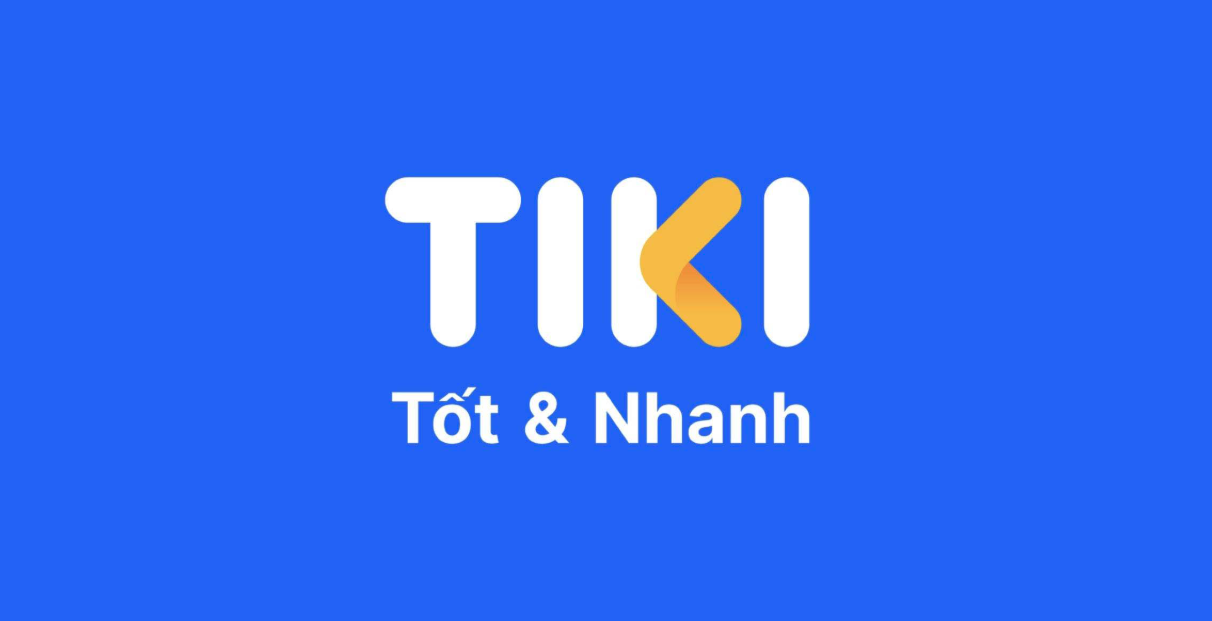

### Table of Contents
* [1. Problem Statement Formulation](#problem-statement-formulation)
  * [1.1 Load and Explore the Data](#load-and-explore-the-data)
  * [1.2 Understand the Data](#understand-the-data)
  * [1.3 Formulate a Value Based Problem Statement](#formulate-a-value-based-problem-statement)
* [2. Exploratory Data Analysis and Data Cleansing](#exploratory-data-analysis-and-data-cleansing)
  * [2.1 Interesting Trends](#interesting-trends)
  * [2.2 Anomalies](#anomalies)
  * [2.3 Potential Errors](#potential-errors)
  * [2.4 Missing Value Treatment](#missing-value-treatment)
* [3. Data Wrangling and Transformation](#data-wrangling-and-transformation)
  * [3.1 Categorical Data](#categorical-data)
  * [3.2 Numerical Data](#numerical-data)
* [4. Machine Learning Modelling](#machine-learning-modelling)
  * [4.1 Show Count of Rows and Columns](#show-count-of-rows-and-columns)
  * [4.2 Sample of 10 Rows before Modelling](#sample-of-10-rows-before-modelling)
  * [4.3 Build the Predictive Model](#build-the-predictive-model)
* [5. Model Evaluation and Selection](#model-evaluation-and-selection)
  * [5.1 Utilize Model Metrics for Evaluation](#utilize-model-metrics-for-evaluation)
  * [5.2 Compare Models and Decide on Final Model](#compare-models-and-decide-on-final-model)
* [6. Summary and Further Improvements](#summary-and-further-improvements)
  * [6.1 Summarize Your Findings](#summarize-your-findings)
  * [6.2 Explain the Possible Further Improvements](#explain-the-possible-further-improvements)
* [7. Assumptions Made](#Assumptions-Made)

* [8. References](#References)

# 1. Problem Statement Formulation

## 1.1 Load and Explore the Data

First, I loaded the dataset from a CSV file using the ‘spark.read.csv’ method with options to manage special characters, multi-line entries, and a custom delimiter which was implemented after much experimentation which would be further explained in the data cleaning section. The header row was read to infer the schema automatically, which is important for understanding the data types of each column. After loading the data, I examined its structure using ‘printSchema()’ to get an overview of the data types and ‘show()’ to view the first 10 rows. Initially, the dataset consisted of 44,804 rows and 18 columns.
Throughout this process, I consistently cross-checked my findings with the original CSV file to ensure that the data was being interpreted correctly and that there were no gaps or missing entries. 
Next, I performed a null value check across all columns to identify any missing data. This step is vital as it helps in assessing the completeness of the dataset. Additionally, I used group-by and aggregation techniques to detect duplicate rows based on the 'id' column, displaying a total of 7,675 duplicates.

## 1.2 Understand the Data

The provided Tiki dataset has contains information on various products listed on a Tiki's platform, products such as backpacks, bags, shoes, and fashion accessories. Each entry includes details such as the product ID, name, description, original and current prices, fulfillment type, brand, review count, average rating, favorite count, and other attributes like vnd cashback offers and whether the product has a video.

## 1.3 Formulate a Value Based Problem Statement

Problem Statement:

This project aims to develop a Sales Quantity Prediction Model using PySpark for a Vietnamese e-retail platform Tiki Vietnam, which will predict the sales quantity (quantity_sold) based on various transaction characteristics such as price, brand, rating, product type, and fulfillment methods.

Stakeholder:

The primary stakeholders are Tiki's Sales, Marketing, and Tiki Seller Center Platform Teams. By implementing a predictive regression model, these teams aim to enhance demand forecasting, evaluate product type performance, and improve satisfaction among consumers, sellers, and suppliers by ensuring consistent product availability.

Value Proposition:

Developing a Sales Quantity Prediction Model using PySpark for Tiki Vietnam empowers the platform to accurately forecast sales based on key transaction characteristics such as price, brand, rating, product type, and fulfillment methods. This data-driven solution enables Tiki's Sales, Marketing, and Seller Center Platform Teams to optimise demand forecasting, refine product type performance evaluation, and ensure consistent product availability. By enhancing operational efficiency and decision-making, the project delivers improved satisfaction for consumers, sellers, and suppliers, and enhancing their experience with Tiki Vietnam. Driving growth and competitiveness in Vietnam's e-retail market. Ultimately driving growth and increasing profitability in the competitive Vietnamese e-commerce market.

# 2. Exploratory Data Analysis and Data Cleansing

## 2.1 Interesting Trends

**First Data Loading Issue:**

During the process of loading a CSV file (originally an Excel file) into a PySpark DataFrame, an issue arose where certain data fields containing commas were incorrectly split into multiple columns. This problem likely stems from PySpark's CSV reader misinterpreting the commas as delimiters rather than as part of the data. For example, product descriptions containing commas (e.g., "Stylish, durable leather backpack") were treated as separate fields instead of remaining as a single value. The root cause lies in the lack of proper handling for quoted strings or escape characters during the CSV parsing process.

Initially, I considered using keyword mapping to classify products into categories based on descriptions. However, a thorough exploration of the dataset revealed inconsistencies in the data that made this approach unreliable. For instance, descriptions for "men's shoes" often did not contain the word "shoes," and some backpack descriptions included unrelated terms like "laptop" while omitting the word "backpack." These discrepancies highlight the limitations of relying solely on keyword-based mapping.

**Second Data Loading Issue:**

Another issue emerged during CSV file loading, where data misalignment occurred. Values in descriptions with commas were split into multiple columns, causing the first two columns to be skipped and the remaining data to shift incorrectly. This happened because fields containing commas were not properly quoted, leading to PySpark misinterpreting the structure. 

To resolve this, I implemented the following steps. Firstly, I used Quote Handling which configured PySpark to recognise and correctly handle values wrapped in quotes using the quote and escape options. Secondly, Delimiter Configuration which specified the correct delimiter (\t for tab-separated values) to ensure that the data was split into columns as expected. Third, File Loading where I used the csv method to load the file into a PySpark DataFrame with header=False (since the file did not contain a header row) and inferSchema=True to automatically determine the column types.

These adjustments ensured proper alignment of data and accurate handling of fields with embedded commas.

**Third Data Loading Issue:**

After cross referencing the number of rows with OEM as the product brand with the CSV file, I identified the column ' OEM' still has missing 8 rows that werent mapped to the actual correct category 'OEM'. To resolve this issue, I identified the affected rows and updated their mappings to correctly assign them to the 'OEM' category.

#### *Matching Tiki Vietnam's brand colours*
![Screenshot 2024-12-13 182254.png](<attachment:Screenshot 2024-12-13 182254.png>)
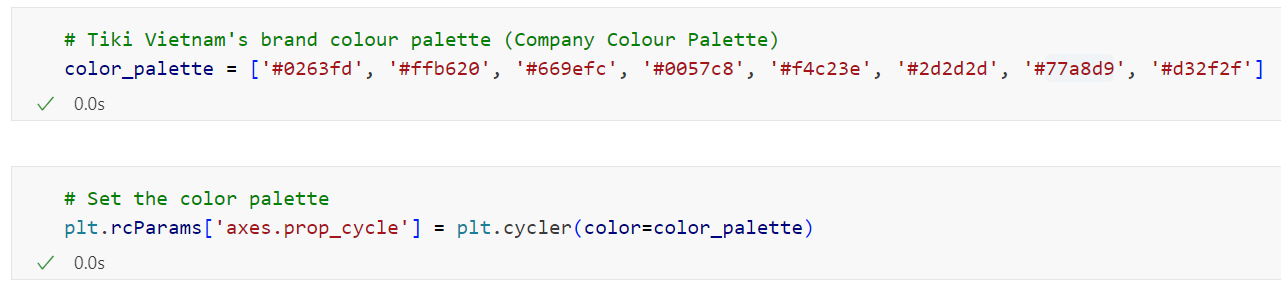

#### *The Top 10 Brands by their Number of Quantity Sold*
![Screenshot 2024-12-13 182522.png](<attachment:Screenshot 2024-12-13 182522.png>)
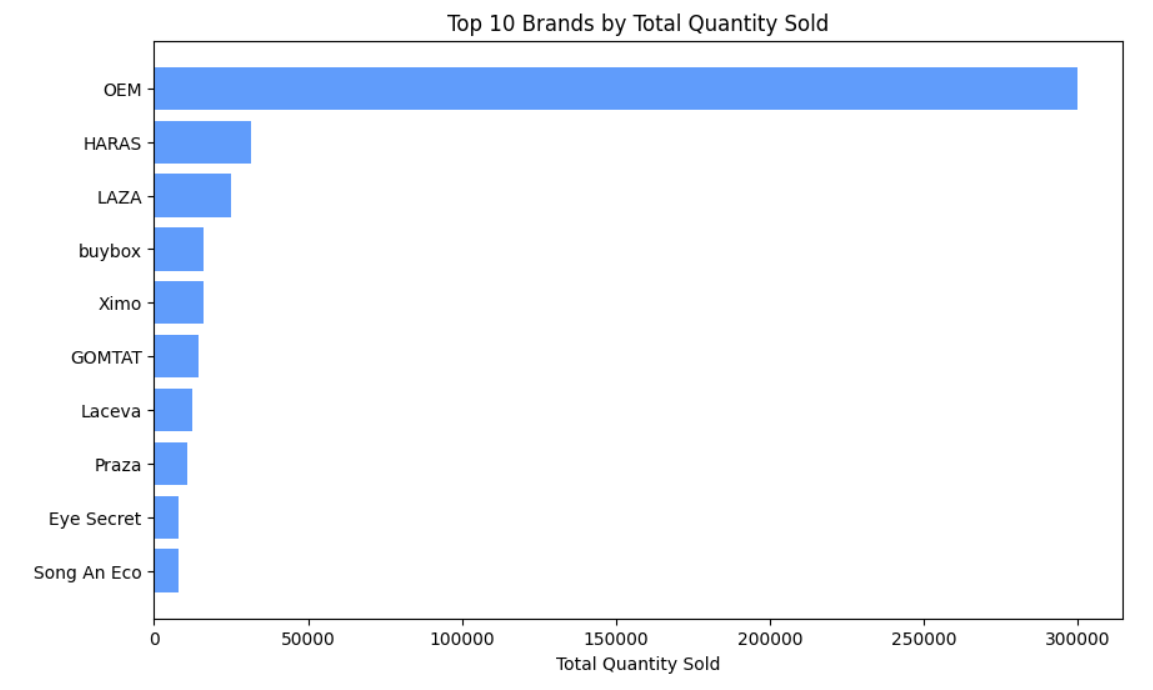

The chart highlights that OEM products drive the highest sales quantities, primarily because they are often more affordable than branded alternatives, appealing to price-sensitive Vietnamese consumers. This affordability enables OEM products to generate higher revenue compared to other categories on Tiki. Consequently, Tiki Vietnam strategically focuses on onboarding more OEM brands, as they not only bring in significant revenue but also provide cost-effective options for consumers, creating a win-win situation for both the platform and its users.

#### *The Top 5 Brands based on the Most Popular Product by Quantity Sold*
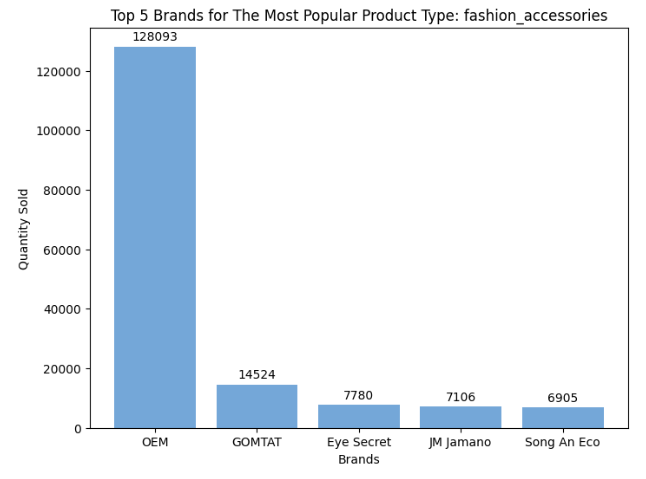

This shows that OEM remains the best-performing product type, even in the highly popular and in-demand category of fashion accessories. Additionally, linking back to the first chart discussed earlier, we can observe that four out of the five brands in this chart also appear in the top 10 brands by quantity sold from the first chart.

#### *The Product Quantity Sold by Day of the Week*
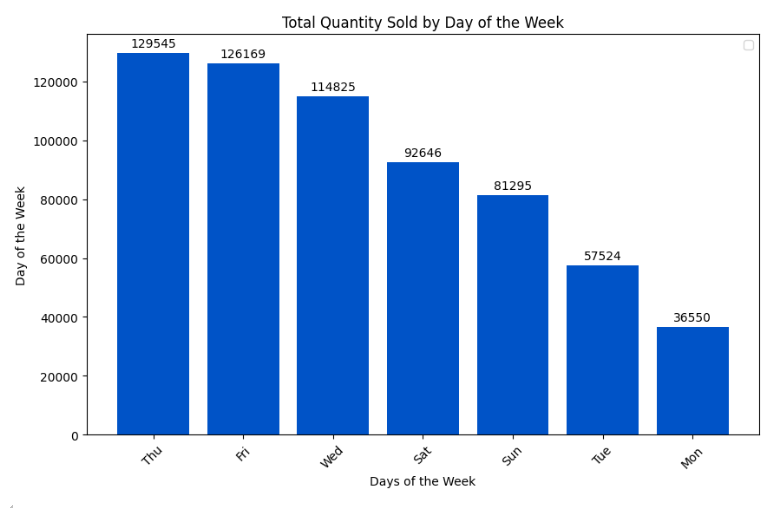

Tiki ran specific marketing promotional programs every Wednesday, Thursday, and Friday during a promotional period. In collaboration with HSBC, the promotional terms from HSBC specified that discounts were available only on these days for eligible cardholders using HSBC credit cards. The offer included a discount of VND 20,000 on purchases and it was limited to the first 150 eligible cardholders each promotional day. This exclusivity made the promotion more attractive and led to a noticeable spike in sales.

Since the promotion started on 1st April 2021, a Thursday, likely attracted a significant initial surge in demand, generating substantial interest and engagement. Thursdays experienced the highest product sales compared to other days of the week, indicating that the marketing for the promotion's opening was particularly effective. Consequently, the top three days with the highest sales were Wednesday, Thursday, and Friday, reflecting the success of the promotional strategy with HSBC.

#### *The Product Quantity Sold by the Months in a Year*
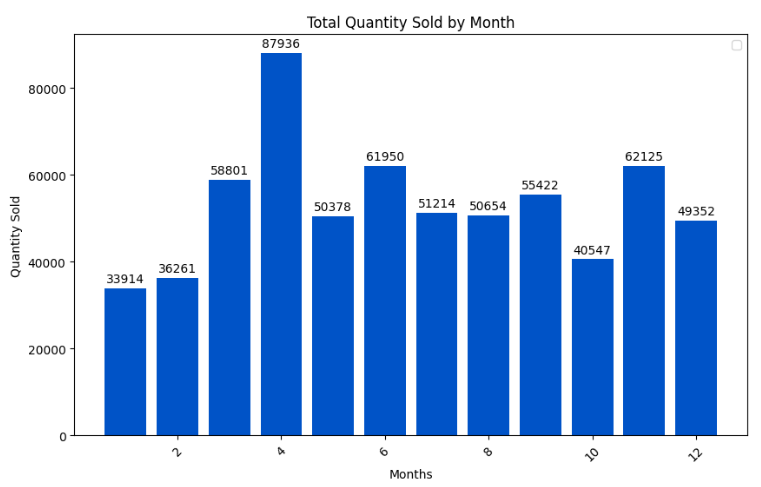

Since the majority of Tiki Vietnam's consumers are Vietnamese, they tend to buy items in anticipation of season changes, particularly in April as Vietnam transitions from the dry to the rainy season. This period sees an increased demand for weather-appropriate products such as rain gear, shoes suitable for wet conditions, and fashion accessories to update wardrobes. The growth of Vietnam's middle class, with more disposable income, further supports this trend, especially for seasonal fashion items. Cultural factors, like Vietnamese holidays and festivals at this time, contribute to increased consumer activity. This seasonal buying behavior highlights how both practical needs and cultural influences drive product sales, particularly in April. Additionally, HSBC promotion stated above that began on April 1st, also contributed to the early market uptake in sales during this month.

#### *The Product Quantity Sold by Year*
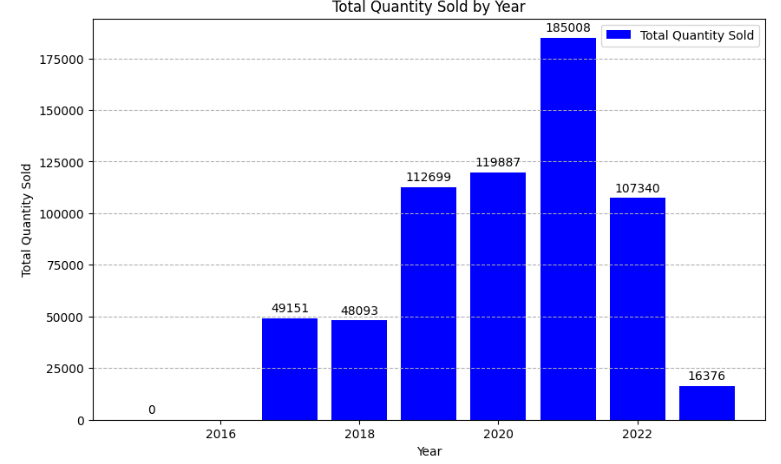

Product sales spiked in 2021 due to the rise in online shopping during COVID-19 but dropped in 2022 with the launch of TikTok Shop in April. TikTok’s integration of social media and e-commerce made it easier for users to discover and purchase products, attracting buyers and increasing competition.

#### *Pearson Correlation Chart*
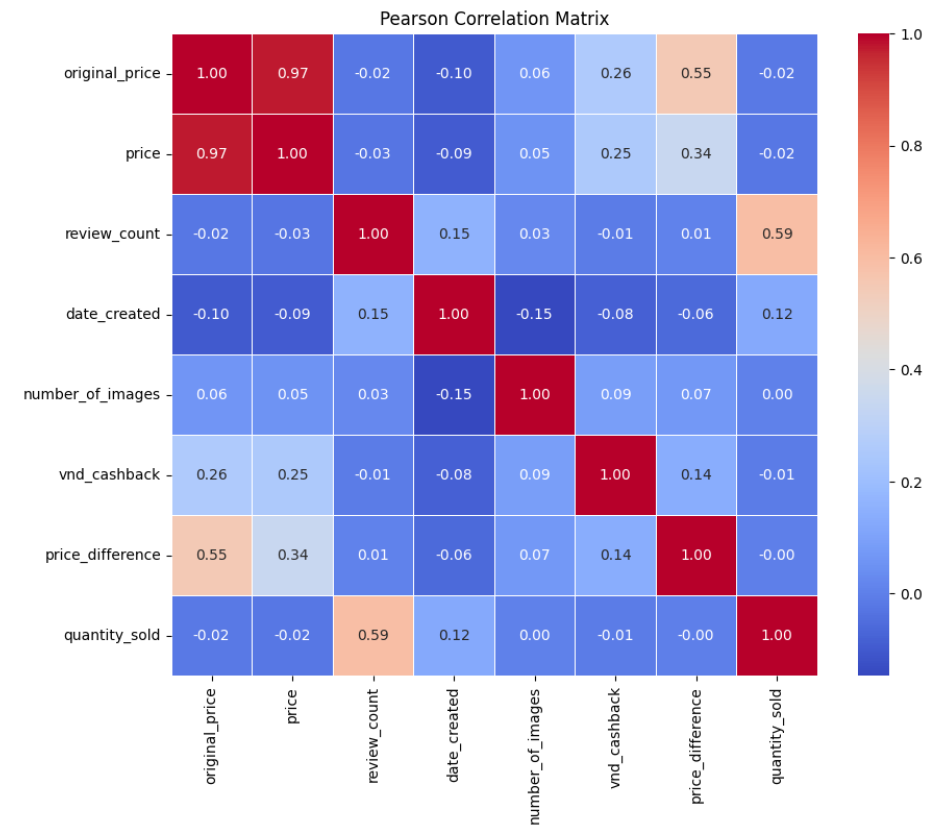
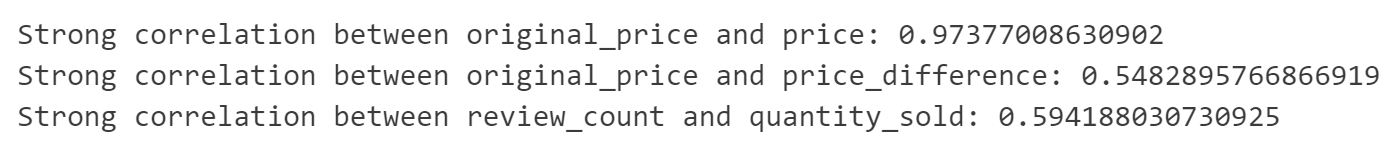


Since there is a strong positive correlation between the number of reviews and sales quantity, Tiki should leverage reviews to drive sales. For underperforming products, marketing campaigns involving well-known influencers can boost visibility and promote sales. For top-performing products with high reviews, further amplifying their visibility through sustained efforts can maximize their potential. Offering incentives like discounts or loyalty points can encourage more customer reviews, while analyzing products with high review counts can provide insights into customer preferences, helping Tiki optimize product listings and recommendations for sustained growth.

## 2.2 Anomalies

In the dataset, there is a listing labeled as a gift, where both the price and original price are recorded as 0. This product, named “(Gift) Canvas Morra bag,” likely represents a promotional item, possibly part of a marketing campaign. It may have been offered for free with the purchase of another product, potentially using a promotion code. 

Only three units were sold, indicating that this marketing tactic was not very effective. I searched for additional listings with the same name but found none, reinforcing the idea that this was a one-time promotion rather than a regular product. The item is associated with the MORRA brand and is listed under the “MORRA OFFICIAL STORE” on Tiki Vietnam, suggesting it was used to enhance brand visibility.

The classification as a gift implies it was intended to incentivize purchases or reward customers, aligning with common “gift-with-purchase” strategies. However, the low sales volume suggests limited marketing effectiveness or narrow eligibility criteria.

Given that this listing is not relevant for predicting quantities sold and could mislead the machine learning model as an outlier, I removed it.

## 2.3 Potential Errors

I also removed rows where the 'date_created' value exceeds 4999 days since the dataset was posted, as Tiki Vietnam was founded in March 2010. This threshold ensures that any date beyond this range is invalid, enhancing the dataset's accuracy and reliability for subsequent analysis. Assumptions were made that the last update date of the listings were on 13th September 2023 as per when the kaggle dataset was posted.

## 2.4 Missing Value Treatment

I've analysed the rating_average column and found it to be moderately skewed to the right with lighter tails, as indicated by the skewness and kurtosis values. To handle the missing values effectively, I've chosen the median imputer, which is more appropriate for skewed data as it is less influenced by outliers and provides a better central tendency for imputation in this scenario. The code creates an imputer instance, fits it on the training data, and transforms both the training and test datasets to replace missing values with the median, adding a new imputed column.

# 3. Data Wrangling and Transformation

## 3.1 Categorical Data

I chose not to encode 'current_seller_cleaned' and 'brand' after string indexing because these columns have too many unique categories. One-hot encoding them would create a high-dimensional sparse matrix, which can increase computational complexity and negatively impact model performance. Instead, they are only string indexed to convert them into numerical indices without expanding the dimensionality excessively. And lastly, I chose to use a pipeline for categorical data handling because it’s consistent, automated, and scalable when handling such transformations. 

## 3.2 Numerical Data

I attempted several transformations including logarithmic, square root, and Yeo-Johnson transformations as well as different combinations of variables used or transformations used to improve my model. Unfortunately, these transformations did not enhance the performance and in fact, they decreased the R2 value to 0.10 or lower and increased the Mean Absolute Error (MAE) of the predictions. As a result, I decided not to use these transformations. However, I have retained the code for these transformations and their results in a commented-out section for future reference. 

Since I applied One-hot encoding, it created multiple columns for some of the categorical features, which can be sparse and high-dimensional. Thus, I performed vectorisation because it standardises and organises the encoded data into a format that can be used effectively for machine learning model training. And lastly, I've also applied the same vectorisation process to both the training and testing datasets (train_vectored and test_vectored) to ensure consistency.

# 4. Machine Learning Modelling

## 4.1 Show Count of Rows and Columns

Before proceeding with modelling, I displayed the number of rows and columns in the dataframe after scaling.

## 4.2 Sample of 10 Rows before Modelling

Before proceeding with modelling, I also displayed 10 rows of data from the dataframe used after scaling.

## 4.3 Build the Predictive Model

I built and tested multiple models, experimenting with different scaling methods such as Standard Scaler, Robust Scaler, and Min Max Scaler. I found that Min Max Scaler was not particularly useful for my dataset, so it was excluded from further analysis. I conducted linear regression models using various scaling techniques and also experimented with different decision tree models, applying cross-validation techniques. In particular, I compared the performance of the Robust Scaler and Standard Scaler. I used the Robust Scaler because this method of scaling was something I've seen only in PySpark and was less common in Pandas. Hence why I wanted to experiment and test if the scaling methods significantly impact the model.

# 5. Model Evaluation and Selection

## 5.1 Utilize Model Metrics for Evaluation

For both Linear Regression models utilising the Robust Scaler and the Standard Scaler, I used several key metrics specifically R2 (coefficient of determination), Mean Squared Error (MSE), and Mean Absolute Error (MAE) to monitor and evaluate model performance. The reason for selecting these metrics is that they provide a comprehensive view of how well the model fits the data. R2 indicates the proportion of variance explained by the model, while MSE and MAE offer insights into the average errors in predictions, allowing for a thorough assessment of accuracy.

Similarly, for the Decision Tree Regression models, I implemented Cross Validation techniques alongside either the Robust Scaler or the Standard Scaler. In this case, I focused on R2 and Root Mean Squared Error (RMSE) as my primary evaluation metrics. The rationale behind this choice is the same reason why I used R2 in the Linear Regression models, while RMSE provides a clear measure of prediction error in the same units as the target variable, facilitating easier interpretation of model performance. 


## 5.2 Compare Models and Decide on Final Model

After comparing all the models, I have chosen the Decision Tree Regressor Model with just the Standard Scaler as the final model. The primary reasons for this choice are its performance metrics and its alignment with the project aim. Among all the models evaluated, this Decision Tree Regressor yielded the highest R2 score of 60%, indicating it explained the largest proportion of variance in the target variable ('quantity_sold'). It also achieved the lowest RMSE (Root Mean Square Error) score of 63.7, signifying the best performing predictions compared to the other models.
Additionally, the model's superior predictive power and performance scores aligns with the project's goal of effectively predicting the product sales quantity sold, enabling more informed decisions on inventory management and resource allocation. Thus, why I believe that this model is the most suitable choice to address the objectives of this project.

#### Final Chosen Model Results
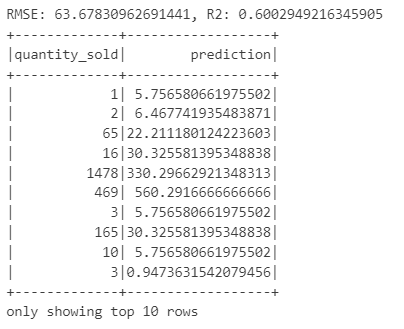

# 6. Summary and Further Improvements

## 6.1 Summarize Your Findings

Key findings from the analysis include the success of the HSBC promotion, which significantly boosted sales, particularly on Thursday, the day the promotion launched. The promotion, limited to Wednesdays, Thursdays, and Fridays, rewarded the top 150 buyers each day, and this pattern is reflected in the charts, with Thursday having the highest sales, followed by Friday and Wednesday. Another insight is that Vietnamese consumers, Tiki’s largest demographic, tend to buy more products before seasonal changes, especially in April.

The year 2022 saw a dip in sales, attributed partly to the competitive entry of TikTok Shop into the market; however, this presents an opportunity for Tiki to leverage live streaming influencers for marketing campaigns on TikTok, capitalising on its effectiveness in driving consumer engagement. Furthermore, a moderate correlation between sales volume and review counts suggests that incentivising customers to leave reviews could enhance product visibility and sales.

Lastly, OEM brands continue to perform exceptionally well, driving revenue and meeting consumer demand across various product categories. Expanding OEM offerings would not only diversify Tiki’s product range but also strengthen its appeal to cost-conscious shoppers.

## 6.2 Explain the Possible Further Improvements

To further enhance the analysis, future improvements could focus on exploring more advanced models and dedicating additional time to coding in PySpark to refine and expand the scope of the models. For instance, developing specialised models tailored to specific business needs could provide deeper insights. Subset models such as analysing how product descriptions and names influence sales quantities by identifying impactful keywords.

Additionally, implementing models focused on marketing effectiveness would require supplementary data, potentially in a separate CSV file, enabling a deeper analysis of the HSBC collaboration promotion's success. These models could uncover insights into the effectiveness of collaborations, such as identifying key factors in the success of the HSBC promotion and applying those findings to optimise future marketing strategies. Ultimately, enabling Tiki to replicate successful elements and optimise promotional efforts for enhanced consumer engagement and sales performance.

# 7. Assumptions Made

My assumption when creating the variables like 'year', 'month', and 'day_of_week' is that the date when the product listing was created corresponds to the date this dataset was published on Kaggle, which is 13th September 2023.

# 8. References

https://card.apply.hsbc.com.vn/happy-weekend/files/Tiki_HSBC_TnC_EN_03-2021.pdf

https://www.morganstanley.com/im/en-sg/institutional-investor/insights/articles/vietnam-emerging-consumer-class.html

https://www.similarweb.com/website/tiki.vn/

https://hanoitimes.vn/vietnamese-consumers-spend-us32-million-daily-on-online-shopping-327503.html

https://www.vietnam-briefing.com/news/understanding-vietnams-middle-class-size-spending-patterns-and-opportunities-for-businesses.html/ 

https://www.metasource.co/shopping-ecommerce-platform-in-vietnam-tiki/

https://gma-asia.com/20-consumers-trends-in-vietnam/